<a href="https://colab.research.google.com/github/QuasimodoCodes/Fuzzy_Temp/blob/main/Fuzzy_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🌱 **GROUP D2 : Fuzzy System**


---



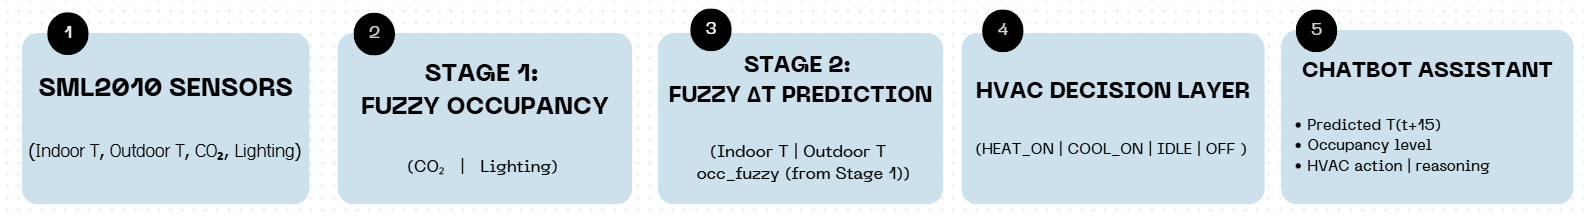

## **Development of a Two-Stage Fuzzy Logic System for Occupancy Detection and 15-Minute Temperature Forecasting using the SML2010 Dataset**

---

🏠 **Imagine This…**

**You just bought a smart climate-control system for your building.**

**It promises to:**

- predict the indoor temperature 15 minutes ahead,

- detect if someone is in the room by reading CO₂ and lighting,

- and automatically decide whether to

  - heat the room,

  - cool it, or

  - turn everything off to save energy.

**Now imagine this system managing a dining room in a family home or office:**

- When people arrive, CO₂ and lights increase → the model knows the room is occupied.

- It forecasts that the room will become warm in 15 minutes → the cooling activates.

- When everyone leaves → CO₂ drops → lights off → the HVAC shuts down automatically.

- Early in the morning, it checks the predicted temperature and warms the room before anyone enters.

**This notebook explores how such a system can be built using:**

- fuzzy logic for occupancy detection,

- a Mamdani FIS for temperature forecasting,

- and a smart HVAC decision layer that chooses the best action.

By the end, we will have a mini intelligent building assistant that can answer:

*“Should I heat, cool, or stay off in the next 15 minutes?”*

---




## 🗂️ **Dataset Description (NEW-DATA-1.T15)**

This dataset contains indoor environmental measurements from a real building recorded in 2012. It is a short-term monitoring dataset, not a full-year recording.

---

### **Date Range**
- **Start:** 13 March 2012  
- **End:** 11 April 2012  
- **Duration:** ~30 days

---

### **Sampling Frequency**
- Measurements recorded every **15 minutes**  
- **96 samples per day** (24 hours × 4)  
- Approximate total rows:


---

### **Train/Test Split**
- `shuffle=False` ensures the **last 20%** of the time-series is used as the test set  
- Therefore, `df_test` contains approximately **6–7 days** of data

---

### **Features Used in This Project**

| Feature Name | Description | Reason for Use |
|--------------|-------------|----------------|
| **Datetime** | Combined timestamp (Date + Time) | Required for time-series slicing, plotting, and the Building Assistant queries |
| **Temperature_Comedor_Sensor** | Indoor temperature | Main variable to predict (T(t+15)) |
| **Temperature_Exterior_Sensor** | Outdoor temperature | Major factor affecting indoor heating/cooling |
| **CO2_Comedor_Sensor** | Indoor CO₂ level (ppm) | Strong natural indicator of occupancy |
| **Lighting_Comedor_Sensor** | Indoor light level (Lux) | Secondary occupancy cue |
| **T_future_15** | Temperature 15 minutes ahead | Prediction target |
| **Delta15** | T_future_15 − current temperature | Represents short-term thermal trend |
| **occ_fuzzy** | Fuzzy occupancy probability (0–1) | Smooth estimate of occupancy |
| **occupied_flag_fuzzy** | Binary occupancy label | For evaluating performance under occupied vs empty periods |

---

### **Why These Features Were Selected**

- Indoor Temperature  
  - Main comfort variable and the prediction target.

- Outdoor Temperature  
  - Drives indoor heat exchange and thermal dynamics.

- CO₂  
  - Excellent proxy for occupancy — people generate CO₂.

- Supports occupancy inference — lights on = people there.

- ΔT and T_future_15  
  - Enable short-term temperature forecasting for HVAC control.

---

### **Short Summary**

> The dataset spans 30 days with 15-minute sampling (≈2880 rows).  
> We use indoor temperature, outdoor temperature, CO₂, and lighting to predict the next 15-minute temperature and to detect occupancy using fuzzy logic.  
> These features enable an occupancy-aware HVAC decision system.




---



### 🌱 **System Overview**
This project uses a **two-stage fuzzy system**:

---



#### **Stage 1 — Fuzzy Occupancy Estimator (CO₂ + Lighting → Occupancy Index)**
- CO₂: {low, medium, high}  
- Lighting: {dark, dim, bright}  
- Output: Occupancy index (0–1) with linguistic sets {low, medium, high}  
- Binary occupancy flag derived with a threshold (e.g., > 0.40)


#### **Stage 2 — 3-Input Temperature Predictor (Indoor T + Outdoor T + Occupancy → ΔT)**
- Indoor temperature: 5 fuzzy sets  
- Outdoor temperature: 5 fuzzy sets  
- Occupancy: 3 fuzzy sets  
- Output ΔT (next 15 minutes): 5 fuzzy sets  
- 18 Mamdani rules
---

### 🌱 **Baselines for Comparison**
- **Persistence model**: T(t+15) = T(t)  
- **Linear Regression** (with occupancy)  
- **3-Input Mamdani FIS** (our model)
---

### 🌱 **Outputs Included**
- Fuzzy membership plots  
- Occupancy detection timeline  
- Historical vs future (test) forecasting  
- Prediction vs ground-truth plots  
- Error analysis by occupancy condition  
- Summary metrics (RMSE, MAE)

---

> 🌱 *This notebook is fully self-contained and uses the cleaned SML2010 T15 dataset. All universes and membership functions are constructed using **training data only** (no leakage).*  



---


# **#0:Setup**

---



In [3]:
!pip install scikit-fuzzy


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import re, numpy as np, pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates



---


# 🌱 **Step 1: Load and Preprocess SML2010**

---
We start by loading the SML2010 T15 dataset, which contains indoor environmental measurements recorded every 15 minutes.  
The original file has a messy single-row header, so we first extract clean column names using a regex pattern.

From the full dataset, we keep only the variables needed for this project:

- **Indoor temperature** (`Temperature_Comedor_Sensor`)
- **Outdoor temperature** (`Temperature_Exterior_Sensor`)
- **CO₂ concentration** (`CO2_Comedor_Sensor`)
- **Lighting level** (`Lighting_Comedor_Sensor`)


In [5]:
# Load the dataset and take out '' irrelevent text for cleaner dataset.
df = pd.read_csv('data/NEW-DATA-1.T15.txt', sep=r'\s+')

In [6]:
# Check columns
print(df.columns.tolist())

['#', '1:Date', '2:Time', '3:Temperature_Comedor_Sensor', '4:Temperature_Habitacion_Sensor', '5:Weather_Temperature', '6:CO2_Comedor_Sensor', '7:CO2_Habitacion_Sensor', '8:Humedad_Comedor_Sensor', '9:Humedad_Habitacion_Sensor', '10:Lighting_Comedor_Sensor', '11:Lighting_Habitacion_Sensor', '12:Precipitacion', '13:Meteo_Exterior_Crepusculo', '14:Meteo_Exterior_Viento', '15:Meteo_Exterior_Sol_Oest', '16:Meteo_Exterior_Sol_Est', '17:Meteo_Exterior_Sol_Sud', '18:Meteo_Exterior_Piranometro', '19:Exterior_Entalpic_1', '20:Exterior_Entalpic_2', '21:Exterior_Entalpic_turbo', '22:Temperature_Exterior_Sensor', '23:Humedad_Exterior_Sensor', '24:Day_Of_Week']


In [7]:
# Print the first 5 rows and shape of the dataset
df = pd.read_csv('data/NEW-DATA-1.T15.txt', header=None)
print(df.head())
print(df.shape)

                                                   0
0  #  1:Date 2:Time 3:Temperature_Comedor_Sensor ...
1  13/03/2012 11:45 18.1875 17.8275 0 216.56 221....
2  13/03/2012 12:00 18.4633 18.1207 6.8 219.947 2...
3  13/03/2012 12:15 18.7673 18.4367 17 219.403 21...
4  13/03/2012 12:30 19.0727 18.7513 18 218.613 21...
(2765, 1)


In [8]:
# Check columns
print(df.iloc[0,0])

#  1:Date 2:Time 3:Temperature_Comedor_Sensor 4:Temperature_Habitacion_Sensor 5:Weather_Temperature 6:CO2_Comedor_Sensor 7:CO2_Habitacion_Sensor 8:Humedad_Comedor_Sensor 9:Humedad_Habitacion_Sensor 10:Lighting_Comedor_Sensor 11:Lighting_Habitacion_Sensor 12:Precipitacion 13:Meteo_Exterior_Crepusculo 14:Meteo_Exterior_Viento 15:Meteo_Exterior_Sol_Oest 16:Meteo_Exterior_Sol_Est 17:Meteo_Exterior_Sol_Sud 18:Meteo_Exterior_Piranometro 19:Exterior_Entalpic_1 20:Exterior_Entalpic_2 21:Exterior_Entalpic_turbo 22:Temperature_Exterior_Sensor 23:Humedad_Exterior_Sensor 24:Day_Of_Week


In [9]:
# ---------------------------------------------------------
# A) DATA CLEANING and TARGET CREATION (T+15) for future prediction
# ---------------------------------------------------------

path = 'data/NEW-DATA-1.T15.txt'

# 1) read just to extract weird header
raw = pd.read_csv(path, header=None)
header_line = raw.iloc[0, 0]

# 2) extract column names  "2:Temperature_..." -> "Temperature_..."
names = re.findall(r'\d+:(\S+)', header_line)

# 3) read real data (skip the header row)
df = pd.read_csv(path, sep=r'\s+', engine='python', skiprows=1, names=names)
print(df.columns)

Index(['Date', 'Time', 'Temperature_Comedor_Sensor',
       'Temperature_Habitacion_Sensor', 'Weather_Temperature',
       'CO2_Comedor_Sensor', 'CO2_Habitacion_Sensor', 'Humedad_Comedor_Sensor',
       'Humedad_Habitacion_Sensor', 'Lighting_Comedor_Sensor',
       'Lighting_Habitacion_Sensor', 'Precipitacion',
       'Meteo_Exterior_Crepusculo', 'Meteo_Exterior_Viento',
       'Meteo_Exterior_Sol_Oest', 'Meteo_Exterior_Sol_Est',
       'Meteo_Exterior_Sol_Sud', 'Meteo_Exterior_Piranometro',
       'Exterior_Entalpic_1', 'Exterior_Entalpic_2', 'Exterior_Entalpic_turbo',
       'Temperature_Exterior_Sensor', 'Humedad_Exterior_Sensor',
       'Day_Of_Week'],
      dtype='object')


In [10]:
# At frist we planed to use HVAC for predcition but in actual data HVAC are never recorded in all 3 threes categories.
print(df['Exterior_Entalpic_turbo'].describe())
print((df['Exterior_Entalpic_turbo'] != 0).sum())
print(df['Exterior_Entalpic_turbo'].unique()[:20])

count    2764.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Exterior_Entalpic_turbo, dtype: float64
0
[0]


In [11]:
# Check current colimns
for c in df.columns:
    print(c)

Date
Time
Temperature_Comedor_Sensor
Temperature_Habitacion_Sensor
Weather_Temperature
CO2_Comedor_Sensor
CO2_Habitacion_Sensor
Humedad_Comedor_Sensor
Humedad_Habitacion_Sensor
Lighting_Comedor_Sensor
Lighting_Habitacion_Sensor
Precipitacion
Meteo_Exterior_Crepusculo
Meteo_Exterior_Viento
Meteo_Exterior_Sol_Oest
Meteo_Exterior_Sol_Est
Meteo_Exterior_Sol_Sud
Meteo_Exterior_Piranometro
Exterior_Entalpic_1
Exterior_Entalpic_2
Exterior_Entalpic_turbo
Temperature_Exterior_Sensor
Humedad_Exterior_Sensor
Day_Of_Week


In [12]:
# Data cleaning
print(df.isnull().sum())   # check NaN counts but DO NOT assign to df
df = df.dropna()
print(df.isnull().sum())   # check again after dropna
print(df.shape)            # row count after dropna

Date                             0
Time                             0
Temperature_Comedor_Sensor       0
Temperature_Habitacion_Sensor    0
Weather_Temperature              0
CO2_Comedor_Sensor               0
CO2_Habitacion_Sensor            0
Humedad_Comedor_Sensor           0
Humedad_Habitacion_Sensor        0
Lighting_Comedor_Sensor          0
Lighting_Habitacion_Sensor       0
Precipitacion                    0
Meteo_Exterior_Crepusculo        0
Meteo_Exterior_Viento            0
Meteo_Exterior_Sol_Oest          0
Meteo_Exterior_Sol_Est           0
Meteo_Exterior_Sol_Sud           0
Meteo_Exterior_Piranometro       0
Exterior_Entalpic_1              0
Exterior_Entalpic_2              0
Exterior_Entalpic_turbo          0
Temperature_Exterior_Sensor      0
Humedad_Exterior_Sensor          0
Day_Of_Week                      0
dtype: int64
Date                             0
Time                             0
Temperature_Comedor_Sensor       0
Temperature_Habitacion_Sensor    0
Weather

In [13]:
print(df)

            Date   Time  Temperature_Comedor_Sensor  \
0     13/03/2012  11:45                     18.1875   
1     13/03/2012  12:00                     18.4633   
2     13/03/2012  12:15                     18.7673   
3     13/03/2012  12:30                     19.0727   
4     13/03/2012  12:45                     19.3721   
...          ...    ...                         ...   
2759  11/04/2012  05:30                     21.1520   
2760  11/04/2012  05:45                     21.0413   
2761  11/04/2012  06:00                     20.9347   
2762  11/04/2012  06:15                     20.8560   
2763  11/04/2012  06:30                     20.7627   

      Temperature_Habitacion_Sensor  Weather_Temperature  CO2_Comedor_Sensor  \
0                           17.8275               0.0000             216.560   
1                           18.1207               6.8000             219.947   
2                           18.4367              17.0000             219.403   
3                  

- We then create the **15-minute-ahead target temperature**:

  \[
  T_{\text{future}} = T(t+15\ \text{min})
  \]

- **and compute the true temperature change**:

  \[
  \Delta T = T_{\text{future}} - T(t)
  \]

- These two values will be used later for fuzzy prediction.


In [14]:
df['Datetime'] = pd.to_datetime(df['Date'] + " " + df['Time'])
print(df[['Date','Time','Datetime']].head())

         Date   Time            Datetime
0  13/03/2012  11:45 2012-03-13 11:45:00
1  13/03/2012  12:00 2012-03-13 12:00:00
2  13/03/2012  12:15 2012-03-13 12:15:00
3  13/03/2012  12:30 2012-03-13 12:30:00
4  13/03/2012  12:45 2012-03-13 12:45:00


C:\Users\chont\AppData\Local\Temp\ipykernel_13732\2441918570.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(df['Date'] + " " + df['Time'])


In [15]:
PATH = 'data/NEW-DATA-1.T15.txt'

# ----------------------------------------------
# ---------- 1) LOAD + BASIC FEATURES ----------
# ----------------------------------------------
raw = pd.read_csv(PATH, header=None)
header_line = raw.iloc[0, 0]
names = re.findall(r'\d+:(\S+)', header_line)

df = pd.read_csv(PATH, sep=r'\s+', engine='python', skiprows=1, names=names)

#  FIRST create Datetime
df['Datetime'] = pd.to_datetime(df['Date'] + " " + df['Time'])

# KEEP: datetime + indoor T, outdoor T, CO2, lighting
df = df[['Datetime',
         'Temperature_Comedor_Sensor',
         'Temperature_Exterior_Sensor',
         'CO2_Comedor_Sensor',
         'Lighting_Comedor_Sensor']].copy()

# 15-min ahead target
df['T_future_15'] = df['Temperature_Comedor_Sensor'].shift(-1)
df = df.dropna().reset_index(drop=True)

# ΔT over next 15 min (true)
df['Delta15'] = df['T_future_15'] - df['Temperature_Comedor_Sensor']
# === FUZZY OCCUPANCY ESTIMATOR (CO2 + lighting → occ_fuzzy) ===

def pct_range(a, lo=1, hi=99, pad=0.05):
    lo_v, hi_v = np.percentile(a, [lo, hi])
    span = hi_v - lo_v
    return lo_v - pad*span, hi_v + pad*span
print(df.head())

             Datetime  Temperature_Comedor_Sensor  \
0 2012-03-13 11:45:00                     18.1875   
1 2012-03-13 12:00:00                     18.4633   
2 2012-03-13 12:15:00                     18.7673   
3 2012-03-13 12:30:00                     19.0727   
4 2012-03-13 12:45:00                     19.3721   

   Temperature_Exterior_Sensor  CO2_Comedor_Sensor  Lighting_Comedor_Sensor  \
0                      18.1150             216.560                  81.6650   
1                      18.4147             219.947                  81.7413   
2                      18.8533             219.403                  81.4240   
3                      19.2907             218.613                  81.5013   
4                      19.7400             217.714                  81.4657   

   T_future_15  Delta15  
0      18.4633   0.2758  
1      18.7673   0.3040  
2      19.0727   0.3054  
3      19.3721   0.2994  
4      19.6407   0.2686  


C:\Users\chont\AppData\Local\Temp\ipykernel_13732\601729262.py:13: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(df['Date'] + " " + df['Time'])


- **Feastures visualization**

---



C:\Users\chont\AppData\Local\Temp\ipykernel_13732\1270322813.py:32: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\chont\PycharmProjects\Fuzzy_Temp\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


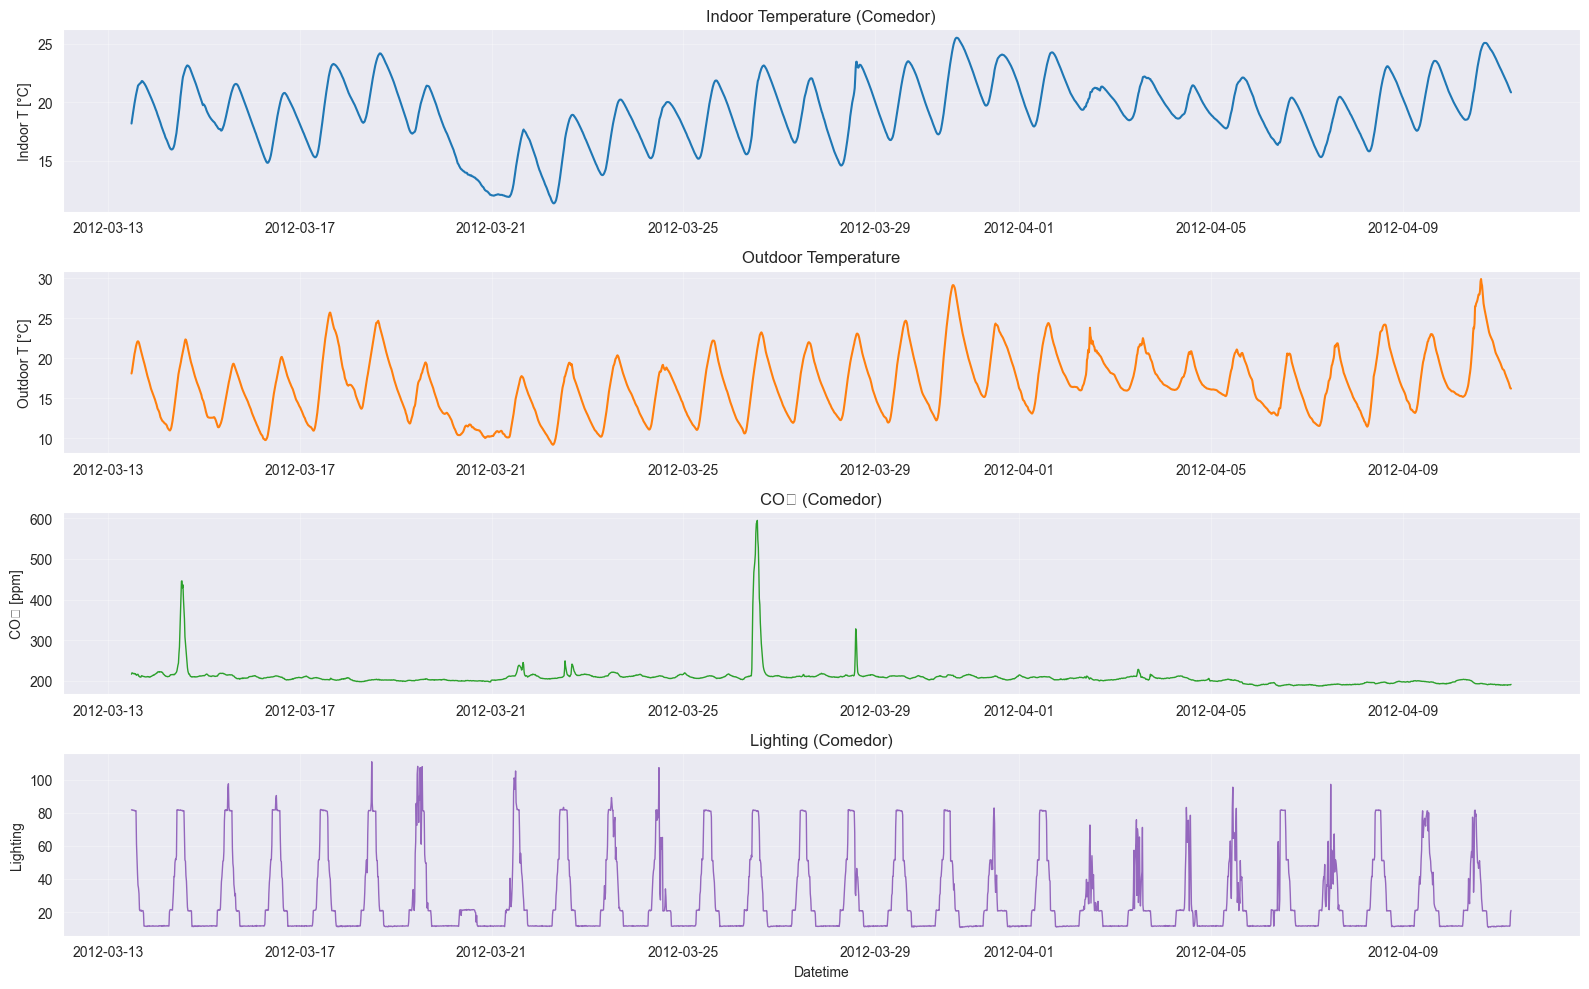

In [16]:
plt.figure(figsize=(16, 10))

# 1) Indoor temperature
plt.subplot(4, 1, 1)
plt.plot(df['Datetime'], df['Temperature_Comedor_Sensor'], linewidth=1.5)
plt.ylabel("Indoor T [°C]")
plt.title("Indoor Temperature (Comedor)")
plt.grid(alpha=0.3)

# 2) Outdoor temperature
plt.subplot(4, 1, 2)
plt.plot(df['Datetime'], df['Temperature_Exterior_Sensor'], linewidth=1.5, color='tab:orange')
plt.ylabel("Outdoor T [°C]")
plt.title("Outdoor Temperature")
plt.grid(alpha=0.3)

# 3) CO₂
plt.subplot(4, 1, 3)
plt.plot(df['Datetime'], df['CO2_Comedor_Sensor'], linewidth=1.0, color='tab:green')
plt.ylabel("CO₂ [ppm]")
plt.title("CO₂ (Comedor)")
plt.grid(alpha=0.3)

# 4) Lighting
plt.subplot(4, 1, 4)
plt.plot(df['Datetime'], df['Lighting_Comedor_Sensor'], linewidth=1.0, color='tab:purple')
plt.ylabel("Lighting")
plt.xlabel("Datetime")
plt.title("Lighting (Comedor)")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Time-Series Feature Overview**

The time-series plots show clear and realistic building behavior across indoor temperature, outdoor temperature, CO₂, and lighting:

- Indoor Temperature: Follows a daily heating–cooling cycle with smooth variations influenced by outdoor temperature and building insulation. No abrupt changes, indicating a stable thermal environment.

- Outdoor Temperature: Shows stronger daily fluctuations and sharper peaks than indoor temperature. Indoor temperature tracks these changes with a delayed and damped response.

- CO₂ (Dining Room): Mostly stable at a low baseline with occasional sharp spikes. These rises correspond to short periods of human presence and ventilation changes, confirming that CO₂ acts as a reliable occupancy indicator.

- Lighting: Displays a clear ON/OFF pattern in regular daily cycles, strongly aligned with occupancy. Peaks in lighting coincide with CO₂ spikes, supporting its use as a primary occupancy feature.

***Conclusion:***
All four signals behave consistently with real building operation. Lighting and CO₂ capture short-term occupancy events, while indoor temperature reflects slower thermal dynamics influenced by outdoor conditions.

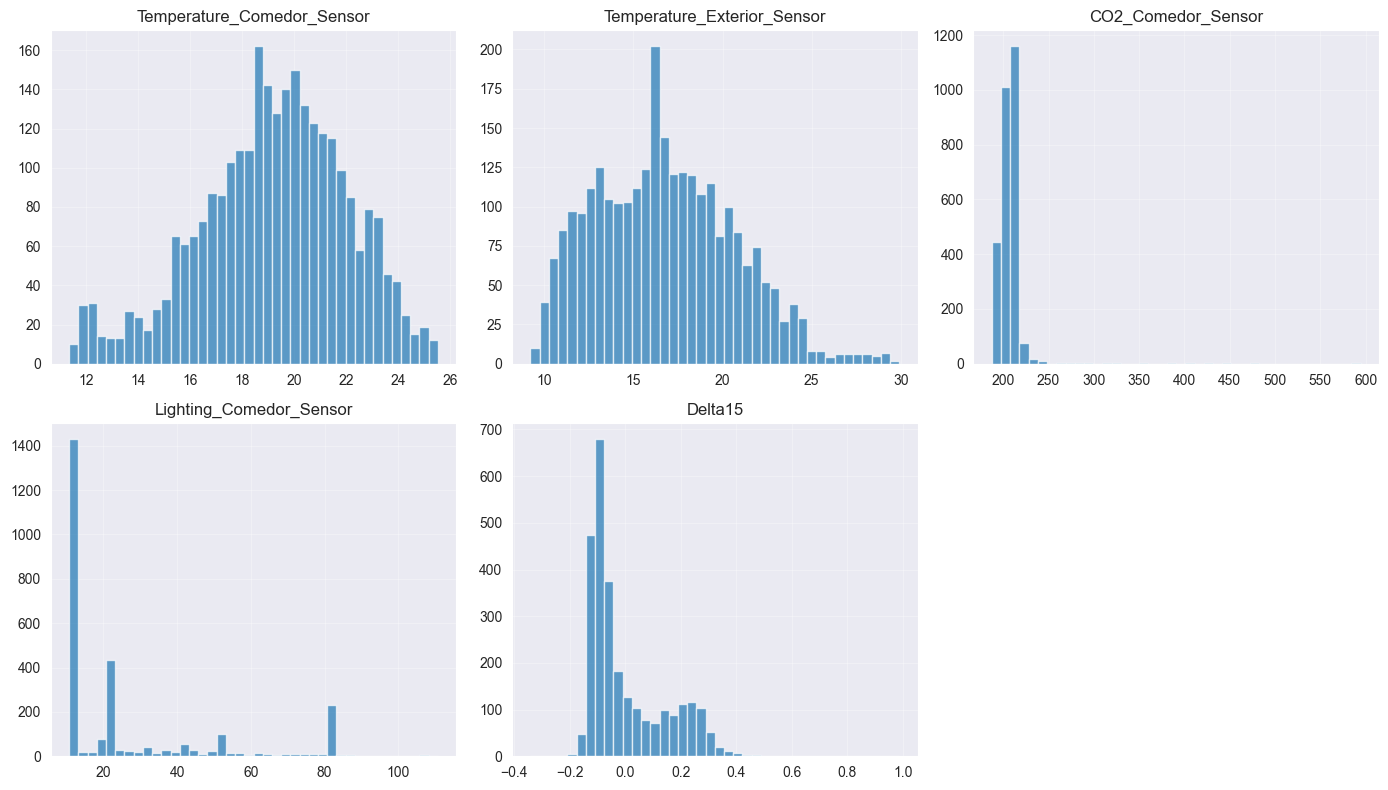

In [17]:
features = [
    'Temperature_Comedor_Sensor',
    'Temperature_Exterior_Sensor',
    'CO2_Comedor_Sensor',
    'Lighting_Comedor_Sensor',
    'Delta15'
]

plt.figure(figsize=(14, 8))

for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    plt.hist(df[col], bins=40, alpha=0.7)
    plt.title(col)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Feature Distribution Summary**

The histograms of all input features show realistic patterns with no values requiring removal:

- Indoor Temperature: Smooth and well-behaved distribution (11–26°C).

- Outdoor Temperature: Natural weather variation (9–30°C).

- CO₂ (Dining Room): Low baseline (~220 ppm) typical for low-cost sensors; spikes represent real occupancy changes.

- Lighting: Strong “lights-off” peak with occasional higher values during activity; all values valid.

- ΔT (15-min Temperature Change): Mostly near zero with occasional larger changes due to real heating/cooling events.

**Conclusion:** All features show plausible behavior, and no outliers were removed since variations reflect real building conditions and sensor characteristics.

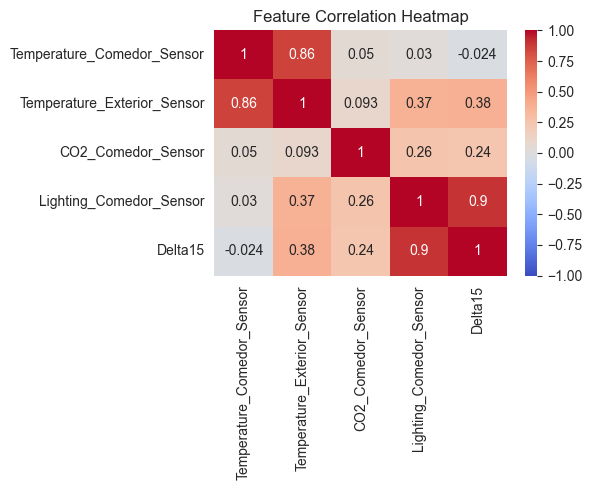

In [18]:
corr = df[['Temperature_Comedor_Sensor',
           'Temperature_Exterior_Sensor',
           'CO2_Comedor_Sensor',
           'Lighting_Comedor_Sensor',
           'Delta15']].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

**Correlation Summary (Heatmap Interpretation)**

- Indoor vs Outdoor Temperature (0.86): Strong correlation — indoor temperature follows outdoor trends with insulation delay.

- Lighting vs ΔT (0.90): Very strong correlation — when lights are on (occupied), indoor temperature tends to rise.

- Outdoor Temperature vs ΔT (0.38): Moderate correlation — warmer outdoor conditions increase indoor warming rate.

- CO₂ vs Lighting (0.26): Weak–moderate correlation — both increase when people are present.

- CO₂ vs ΔT (0.24): Mild positive influence — human presence slightly increases warming.

- Indoor Temp vs CO₂ (0.05): Almost no direct correlation — temperature reacts slowly, while CO₂ changes immediately.

**Conclusion:**

Occupancy-related signals (lighting, CO₂) correlate well with short-term temperature changes (ΔT), supporting their use in a fuzzy occupancy predictor. Meanwhile, indoor temperature is mainly influenced by outdoor temperature and building thermal behavior.



---


##🌱 **Step 2: Fuzzy Occupancy Estimation (CO₂ and Lighting to Occupancy)**

---

Since the dataset contains **no direct occupancy labels**, we build a **fuzzy logic system** to estimate whether the room is occupied.


#### **Membership Functions Created**
We define fuzzy sets for:

**CO₂:**  
- low  
- medium  
- high  

**Lighting:**  
- dark  
- dim  
- bright  

**Occupancy (output):**  
- low  
- medium  
- high  

Ranges for each variable are computed from training data percentiles using `pct_range()` to avoid outliers dominating the scale.

---
#### **Fuzzy Rules**
A set of intuitive Mamdani rules is used, for example:

- If **light is dark** AND **CO₂ is low**, then occupancy is **low**  
- If **light is bright** AND **CO₂ is medium**, then occupancy is **high**  
- If **only one signal is high**, output is **medium**  
- If **both CO₂ and light are high**, occupancy is **high**

These rules express typical human activity patterns.

---
#### **Fuzzy Inference**
For each time step:

1. CO₂ and lighting values are fed into the fuzzy system  
2. A continuous occupancy score (0–1) is produced  
3. A binary flag is created: **1 if score > 0.4 otherwise 0**


This occupancy estimate becomes a **key input** for the temperature prediction FIS.

---

### 🌱 **Output of This Step**
The dataframe now includes:

- `occ_fuzzy` — a fuzzy occupancy score between 0 and 1  
- `occupied_flag_fuzzy` — a binary occupancy detection  
- Clean features for temperature forecasting  



C:\Users\chont\PycharmProjects\Fuzzy_Temp\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


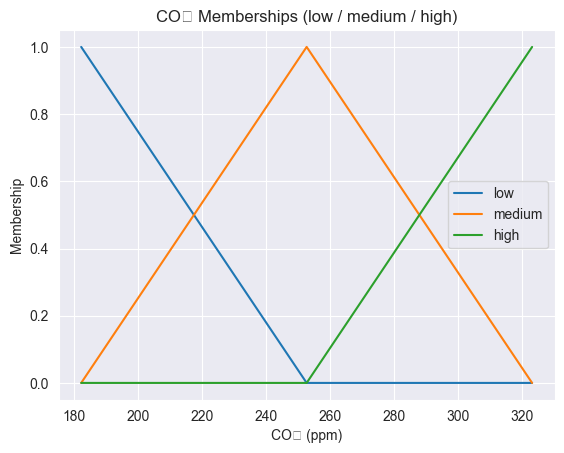

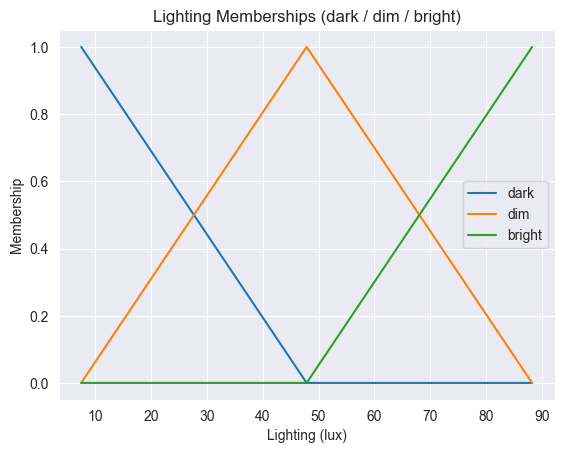

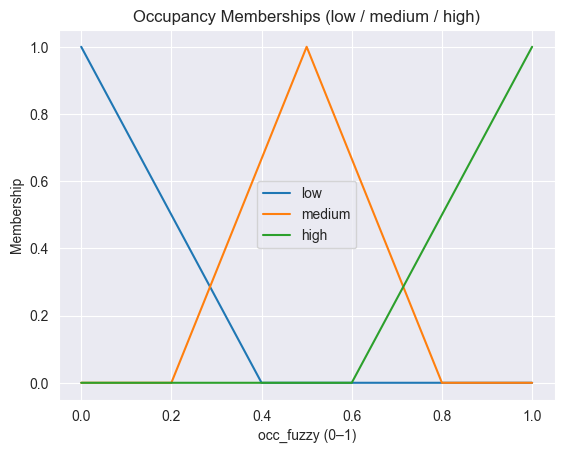

                  Datetime  Temperature_Comedor_Sensor  \
count                 2763                 2763.000000   
mean   2012-03-27 21:00:00                   19.199156   
min    2012-03-13 11:45:00                   11.352000   
25%    2012-03-20 16:22:30                   17.450300   
50%    2012-03-27 21:00:00                   19.373300   
75%    2012-04-04 01:37:30                   21.230650   
max    2012-04-11 06:15:00                   25.540000   
std                    NaN                    2.853676   

       Temperature_Exterior_Sensor  CO2_Comedor_Sensor  \
count                  2763.000000         2763.000000   
mean                     16.758018          208.485246   
min                       9.223330          187.339000   
25%                      13.661350          200.906500   
50%                      16.492700          207.051000   
75%                      19.400300          211.248000   
max                      29.908000          594.389000   
std          

In [19]:
#-------------------------------------------------------------------
#  2) FUZZY OCCUPANCY (CO2 + LIGHT → occ_fuzzy)
#-------------------------------------------------------------------

#  Since the dataset contains **no direct occupancy labels**, we build a **fuzzy logic system** to estimate whether the room is occupied.
co2 = df['CO2_Comedor_Sensor'].values
light = df['Lighting_Comedor_Sensor'].values

co2_lo, co2_hi     = pct_range(co2,   1, 99, 0.05)
light_lo, light_hi = pct_range(light, 1, 99, 0.05)

# Universes
co2_var   = ctrl.Antecedent(np.linspace(co2_lo,   co2_hi,   401), 'co2')
light_var = ctrl.Antecedent(np.linspace(light_lo, light_hi, 401), 'light')
occ_var   = ctrl.Consequent(np.linspace(0,        1,        201), 'occ')

# CO2: low / medium / high
co2_var['low']    = fuzz.trimf(co2_var.universe,   [co2_lo,             co2_lo,            (co2_lo+co2_hi)/2])
co2_var['medium'] = fuzz.trimf(co2_var.universe,   [co2_lo,             (co2_lo+co2_hi)/2, co2_hi])
co2_var['high']   = fuzz.trimf(co2_var.universe,   [(co2_lo+co2_hi)/2,  co2_hi,            co2_hi])

# Lighting: dark / dim / bright
light_var['dark']   = fuzz.trimf(light_var.universe, [light_lo,              light_lo,             (light_lo+light_hi)/2])
light_var['dim']    = fuzz.trimf(light_var.universe, [light_lo,              (light_lo+light_hi)/2, light_hi])
light_var['bright'] = fuzz.trimf(light_var.universe, [(light_lo+light_hi)/2, light_hi,             light_hi])

# Occupancy: low / medium / high (0–1)
occ_var['low']    = fuzz.trimf(occ_var.universe, [0.0, 0.0, 0.4])
occ_var['medium'] = fuzz.trimf(occ_var.universe, [0.2, 0.5, 0.8])
occ_var['high']   = fuzz.trimf(occ_var.universe, [0.6, 1.0, 1.0])

# ---------------------------------------------------------
# Plot Stage 1 membership functions (CO2, Light, Occupancy)
# ---------------------------------------------------------

# CO2 membership functions
plt.figure()
for term in co2_var.terms:
    plt.plot(co2_var.universe, co2_var[term].mf, label=term)
plt.title('CO₂ Memberships (low / medium / high)')
plt.xlabel('CO₂ (ppm)')
plt.ylabel('Membership')
plt.legend()
plt.show()

# Lighting membership functions
plt.figure()
for term in light_var.terms:
    plt.plot(light_var.universe, light_var[term].mf, label=term)
plt.title('Lighting Memberships (dark / dim / bright)')
plt.xlabel('Lighting (lux)')
plt.ylabel('Membership')
plt.legend()
plt.show()

# Occupancy membership functions
plt.figure()
for term in occ_var.terms:
    plt.plot(occ_var.universe, occ_var[term].mf, label=term)
plt.title('Occupancy Memberships (low / medium / high)')
plt.xlabel('occ_fuzzy (0–1)')
plt.ylabel('Membership')
plt.legend()
plt.show()

# Rules
rules_occ = [
    ctrl.Rule(light_var['dark']   & co2_var['low'],    occ_var['low']),
    ctrl.Rule(light_var['bright'] & co2_var['low'],    occ_var['medium']),
    ctrl.Rule(light_var['dim']    & co2_var['medium'], occ_var['medium']),
    ctrl.Rule(light_var['bright'] & co2_var['medium'], occ_var['high']),
    ctrl.Rule(light_var['bright'] & co2_var['high'],   occ_var['high']),
    ctrl.Rule(light_var['dim']    & co2_var['high'],   occ_var['high']),
]

occ_system = ctrl.ControlSystem(rules_occ)
occ_sim = ctrl.ControlSystemSimulation(occ_system)

occ_fuzzy = np.zeros(len(df))
for i in range(len(df)):
    occ_sim.input['co2']   = float(df.iloc[i]['CO2_Comedor_Sensor'])
    occ_sim.input['light'] = float(df.iloc[i]['Lighting_Comedor_Sensor'])
    occ_sim.compute()
    occ_fuzzy[i] = occ_sim.output['occ']

df['occ_fuzzy'] = occ_fuzzy
df['occupied_flag_fuzzy'] = (df['occ_fuzzy'] > 0.4).astype(int)

print(df.describe())



---


## 🌱 **Step 3: Train/Test Split (Chronological)**

---



To evaluate the fuzzy temperature prediction model fairly, we create a **chronological train/test split**.

Because this is **time-series data**, we **must not shuffle** the samples.  
Shuffling would break the temporal order and cause future information to leak into the past.

#### 🌱 **Input features used for learning**
We train the model using three variables:

- **Indoor temperature**
- **Outdoor temperature**
- **Fuzzy occupancy score** (`occ_fuzzy`) - produced by our Stage 1 fuzzy occupancy estimator

These represent the system's understanding of the current physical and human-driven conditions in the room.

#### 🌱 **Output (target)**
- **T_future_15** — the indoor temperature 15 minutes ahead

This allows the FIS to learn the relationship between current conditions and future temperature.

#### 🌱 **80/20 chronological split**
- **80%** of the earliest samples → training  
- **20%** of the most recent samples → testing (future prediction)

This simulates *real forecasting*:  
the model learns from past data and is tested on **unseen future data**.

#### 🌱 **Extracting clean arrays for building universes**
From the training section we extract:

- `indo_train`: indoor temperature values  
- `out_train`: outdoor temperature values  
- `occ_train`: fuzzy occupancy values  
- `Delta15_train`: true ΔT for training only

These arrays are used to compute **data-driven ranges (universes)** for the fuzzy membership functions.  
This ensures that our FIS is built using **only training data**, preventing data leakage.

In [20]:
# ---------------------------------------------------------
#  3) TRAIN/TEST SPLIT
# ---------------------------------------------------------

X = df[['Temperature_Comedor_Sensor',
        'Temperature_Exterior_Sensor',
        'occ_fuzzy']]   # <-- use fuzzy occupancy here
y = df['T_future_15']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

indo_train = X_train['Temperature_Comedor_Sensor'].values
out_train  = X_train['Temperature_Exterior_Sensor'].values
occ_train  = X_train['occ_fuzzy'].values      # <-- was occ_index
Delta15_train = y_train.values - indo_train

# Also keep datetime for plotting later
dt_train = df['Datetime'].iloc[X_train.index].to_numpy()
dt_test  = df['Datetime'].iloc[X_test.index].to_numpy()

print(len(X_train), "train samples")
print(len(X_test),  "test samples")

2210 train samples
553 test samples




---


##🌱 **Step 4: Baseline Models for Comparison**

---
Before evaluating our fuzzy logic model, we establish two baseline models.  
These baselines help us understand whether the fuzzy system provides any real improvement.


### 🌱 **a) Persistence Baseline (T(t+15) = T(t))**

---



The simplest possible forecasting model assumes:

  \[
  T_{\text{future}} = T_{\text{now}}
  \]

This means the temperature is expected to **remain unchanged** for the next 15 minutes.

- It requires **no learning**
- It often performs surprisingly well for smooth indoor temperature dynamics
- It is a strong benchmark for evaluating short-term predictors

We compute its **RMSE** and **MAE** over the test set.

---

In [21]:
# --- Persistence baseline: T(t+15) = T(t) ---
y_true = y_test.values
y_pred_persist = X_test['Temperature_Comedor_Sensor'].values

rmse_pers = np.sqrt(mean_squared_error(y_true, y_pred_persist))
mae_pers  = mean_absolute_error(y_true, y_pred_persist)

print("=== Persistence baseline ===")
print("RMSE:", rmse_pers)
print("MAE :", mae_pers)


=== Persistence baseline ===
RMSE: 0.12786849561163188
MAE : 0.10987613019891501


### 🌱 **b) Linear Regression (with Fuzzy Occupancy)**

Next, we train a simple machine learning model:

\[
T(t+15) = f(\text{indoor temp},\ \text{outdoor temp},\ \text{fuzzy occupancy})
\]

This model includes:
- Indoor temperature  
- Outdoor temperature  
- Fuzzy occupancy score (`occ_fuzzy`)

Linear Regression provides a **strong numeric baseline** because it:
- Captures linear relationships  
- Uses all three input features  
- Sets a standard for model performance  

Comparing the fuzzy system against Linear Regression tells us whether fuzzy rules can capture additional non-linear or human-driven effects.


In [22]:

X_lr_train = X_train[['Temperature_Comedor_Sensor',
                      'Temperature_Exterior_Sensor',
                      'occ_fuzzy']]
X_lr_test  = X_test[['Temperature_Comedor_Sensor',
                     'Temperature_Exterior_Sensor',
                     'occ_fuzzy']]


lr = LinearRegression()
lr.fit(X_lr_train, y_train)

y_pred_lr = lr.predict(X_lr_test)

rmse_lr = np.sqrt(mean_squared_error(y_true, y_pred_lr))
mae_lr  = mean_absolute_error(y_true, y_pred_lr)

print("=== Linear regression (with occupancy) ===")
print("RMSE:", rmse_lr)
print("MAE :", mae_lr)

=== Linear regression (with occupancy) ===
RMSE: 0.045047314584392734
MAE : 0.03306560503280902


### 🌱 **Outputs Measured**

---


For both baselines we compute:

- **RMSE** (Root Mean Squared Error)  
- **MAE** (Mean Absolute Error)  

These will later be compared against the fuzzy system's performance.

---
## 🌱**Step 5: Design of the 3-Input Mamdani Fuzzy System (Indoor T, Outdoor T, Occupancy → ΔT)**

---
In this step we build the main fuzzy inference system (FIS) that predicts the **change in indoor temperature over the next 15 minutes**:

\[
\Delta T = T(t+15\ \text{min}) - T(t)
\]

The FIS uses three inputs:

- **Indoor temperature** (current room temperature)  
- **Outdoor temperature**  
- **Fuzzy occupancy level** (from Stage 1: `occ_fuzzy`)  

and outputs:

- **ΔT** — how much the indoor temperature will go up or down in the next 15 minutes.

---

#### **5.1 Data-driven universes for fuzzy variables**

To make the membership functions realistic, we compute the ranges (`lo`, `hi`) of each variable **from the training data only**, using percentiles:

- `indo_lo`, `indo_hi` → range of indoor temperature  
- `out_lo`, `out_hi` → range of outdoor temperature  
- `occ_lo`, `occ_hi` → range of fuzzy occupancy  
- `d_lo`, `d_hi` → range of true ΔT (temperature change)

These are then used to define the **universe of discourse** for each fuzzy variable:

- `indoor`  → Antecedent (input)  
- `outdoor` → Antecedent (input)  
- `occupancy` → Antecedent (input)  
- `delta`  → Consequent (output ΔT)

---

#### **5.2 Membership functions**

We define linguistic terms for each variable:

**Indoor / Outdoor temperature (5 terms):**

- `very_cold`, `cold`, `normal`, `warm`, `hot`  
- Implemented using trapezoidal and triangular membership functions over `[indo_lo, indo_hi]` and `[out_lo, out_hi]`.

**Occupancy (3 terms):**

- `low`, `medium`, `high`  
- Defined on `[occ_lo, occ_hi]` using overlapping triangular/trapezoidal functions.

**ΔT (output) (5 terms):**

- `strong_down`  → strong cooling  
- `slight_down`  → small cooling  
- `stable`       → almost no change  
- `slight_up`    → small warming  
- `strong_up`    → strong warming  

These sets allow the FIS to express “if–then” rules in intuitive human language.

---

#### **5.3 Fuzzy rule base (18 Mamdani rules)**

We then construct a rule base that links the three inputs to the expected ΔT.  
Examples:

- If **indoor is very cold** AND **outdoor is hot** AND **occupancy is medium or high**  
  → then ΔT is **strong_up** (room will heat up quickly).

- If **indoor is hot** AND **outdoor is cold** AND **occupancy is low**  
  → then ΔT is **strong_down** (room cools quickly, no people inside).

- If **indoor is normal** AND **outdoor is normal** AND **occupancy is high**  
  → then ΔT is **slight_up** (people add a bit of heat).

- If **indoor and outdoor are similar** and occupancy is low/medium  
  → then ΔT is **stable**.

The final rule list (18 rules) covers:

- Heating scenarios (outdoor ≫ indoor)  
- Cooling scenarios (indoor ≫ outdoor)  
- Stable scenarios (similar temperatures)  
- The moderating effect of **occupancy** (more people → more warming).

---

#### **5.4 FIS object**

Finally, all rules are combined into:

```python
system = ctrl.ControlSystem(rules)


In [23]:
indo_lo, indo_hi = pct_range(indo_train, 1, 99, 0.05)
out_lo,  out_hi  = pct_range(out_train,  1, 99, 0.05)
occ_lo,  occ_hi  = pct_range(occ_train,  1, 99, 0.05)
d_lo,    d_hi    = pct_range(Delta15_train, 5, 95, 0.03)

indoor     = ctrl.Antecedent(np.linspace(indo_lo, indo_hi, 401), 'indoor')
outdoor    = ctrl.Antecedent(np.linspace(out_lo,  out_hi,  401), 'outdoor')
occupancy  = ctrl.Antecedent(np.linspace(occ_lo,  occ_hi,  201), 'occupancy')
delta      = ctrl.Consequent(np.linspace(d_lo,    d_hi,    401), 'delta')

def five_terms(var, lo, hi, names=('very_cold','cold','normal','warm','hot')):
    a, b, c, d, e = np.linspace(lo, hi, 5)
    var[names[0]] = fuzz.trapmf(var.universe, [lo, lo, a, b])
    var[names[1]] = fuzz.trimf(var.universe, [a, (a+b)/2, c])
    var[names[2]] = fuzz.trimf(var.universe, [b, (b+c)/2, d])
    var[names[3]] = fuzz.trimf(var.universe, [c, (c+d)/2, e])
    var[names[4]] = fuzz.trapmf(var.universe, [d, e, hi, hi])

def three_terms(var, lo, hi, names=('low','medium','high')):
    a, b, c = np.linspace(lo, hi, 3)
    var[names[0]] = fuzz.trapmf(var.universe, [lo, lo, a, b])
    var[names[1]] = fuzz.trimf(var.universe, [a, (a+b)/2, c])
    var[names[2]] = fuzz.trapmf(var.universe, [b, c, hi, hi])

def five_terms_delta(var, lo, hi):
    a, b, c, d, e = np.linspace(lo, hi, 5)
    var['strong_down'] = fuzz.trapmf(var.universe, [lo, lo, a, b])
    var['slight_down'] = fuzz.trimf(var.universe, [a, (a+b)/2, c])
    var['stable']      = fuzz.trimf(var.universe, [b, (b+c)/2, d])
    var['slight_up']   = fuzz.trimf(var.universe, [c, (c+d)/2, e])
    var['strong_up']   = fuzz.trapmf(var.universe, [d, e, hi, hi])

five_terms(indoor,  indo_lo, indo_hi)
five_terms(outdoor, out_lo,  out_hi)
three_terms(occupancy, occ_lo, occ_hi)
five_terms_delta(delta, d_lo, d_hi)

occ_low    = occupancy['low']
occ_med    = occupancy['medium']
occ_high   = occupancy['high']

rules = [
    ctrl.Rule(indoor['very_cold'] & outdoor['hot']   & (occ_med | occ_high), delta['strong_up']),
    ctrl.Rule(indoor['cold']      & outdoor['hot']   & (occ_med | occ_high), delta['strong_up']),
    ctrl.Rule(indoor['very_cold'] & outdoor['warm']  & occ_high,             delta['slight_up']),
    ctrl.Rule(indoor['cold']      & outdoor['warm']  & occ_high,             delta['slight_up']),
    ctrl.Rule(indoor['normal']    & outdoor['warm']  & occ_low,              delta['slight_up']),
    ctrl.Rule(indoor['normal']    & outdoor['warm']  & occ_high,             delta['slight_up']),
    ctrl.Rule(indoor['normal']    & outdoor['hot']   & occ_med,              delta['slight_up']),
    ctrl.Rule(indoor['normal']    & outdoor['normal'] & occ_low,             delta['stable']),
    ctrl.Rule(indoor['normal']    & outdoor['normal'] & occ_high,            delta['slight_up']),
    ctrl.Rule(indoor['warm']      & outdoor['warm']   & (occ_low | occ_med), delta['stable']),
    ctrl.Rule(indoor['cold']      & outdoor['cold']   & (occ_low | occ_med), delta['stable']),
    ctrl.Rule(indoor['warm']      & outdoor['normal'] & occ_low,             delta['slight_down']),
    ctrl.Rule(indoor['warm']      & outdoor['normal'] & occ_high,            delta['stable']),
    ctrl.Rule(indoor['hot']       & outdoor['normal'] & occ_low,             delta['slight_down']),
    ctrl.Rule(indoor['hot']       & outdoor['cold']   & occ_low,             delta['strong_down']),
    ctrl.Rule(indoor['hot']       & outdoor['cold']   & occ_high,            delta['slight_down']),
    ctrl.Rule(indoor['very_cold'] & outdoor['very_cold'] & (occ_low | occ_med), delta['stable']),
    ctrl.Rule(indoor['hot']       & outdoor['hot']       & (occ_low | occ_med),  delta['stable']),
]

system = ctrl.ControlSystem(rules)

print("\n=== FIS Design Summary (3-input) ===")
print(f"Inputs: indoor {indo_lo:.2f}..{indo_hi:.2f} °C, "
      f"outdoor {out_lo:.2f}..{out_hi:.2f} °C, "
      f"occupancy {occ_lo:.3f}..{occ_hi:.3f}")
print(f"Output: delta  {d_lo:.3f}..{d_hi:.3f} °C")
print("Fuzzy sets: indoor=5, outdoor=5, occupancy=3, delta=5")
print("Rules:", len(rules))


=== FIS Design Summary (3-input) ===
Inputs: indoor 11.34..25.20 °C, outdoor 9.25..26.48 °C, occupancy 0.185..0.893
Output: delta  -0.145..0.292 °C
Fuzzy sets: indoor=5, outdoor=5, occupancy=3, delta=5
Rules: 18


---


## **Step 6: Inference on Test Set and Performance Evaluation**

---
In this step, we use the trained **3-input Mamdani FIS** to make predictions on the **test set** and compare it against the baseline models.



---

#### **6.1 Fuzzy inference for each test sample**

For every sample in the test set:

1. We create a new `ControlSystemSimulation` object.
2. We feed in:
   - `indoor`    → current indoor temperature  
   - `outdoor`   → current outdoor temperature  
   - `occupancy` → fuzzy occupancy score `occ_fuzzy`
3. The fuzzy system infers a **crisp ΔT** (temperature change over the next 15 minutes).
4. We store this output in `pred_delta_test`.

To avoid unrealistic extrapolations, we **clip** the predicted ΔT within the range `[d_lo, d_hi]` learned from the training data.

---

#### **6.2 Recovering T(t+15) from ΔT**

The fuzzy system predicts ΔT, so we reconstruct the **15-minute-ahead temperature** as:

\[
\hat{T}_{\text{fuzzy}}(t+15) = T_{\text{now}} + \hat{\Delta T}
\]

This gives us `y_fuzzy_test`, which can be directly compared to the true target `y_true_test`.

For reference, we also compute:

- `y_persist_test` — the persistence baseline  
- `y_pred_lr` — predictions from the linear regression model  

---

#### **6.3 Performance metrics**

We evaluate all three models using:

- **RMSE** (Root Mean Squared Error)  
- **MAE** (Mean Absolute Error)
---
Reported models:

- **FIS (Mamdani, 3-input)**  
  - Uses indoor temp, outdoor temp, and fuzzy occupancy  
  - Captures non-linear and human-related effects via rules

- **Persistence**  
  - Assumes no change: \( T(t+15) = T(t) \)  
  - Simple but strong baseline for smooth dynamics

- **Linear Regression (with occupancy)**  
  - Data-driven numeric benchmark using the same three inputs  

These metrics tell us:

- Whether the **fuzzy system improves on persistence**  
- How it compares to a **standard ML model** (linear regression)  
- How useful the **fuzzy occupancy signal** is for short-term forecasting

In [24]:
# ---------------------------------------------------------
# 6) INFERENCE ON TEST (with occupancy)
# ---------------------------------------------------------

pred_delta_test = np.zeros(len(X_test))
for i in range(len(X_test)):
    sim = ctrl.ControlSystemSimulation(system)
    sim.input['indoor']    = float(X_test.iloc[i]['Temperature_Comedor_Sensor'])
    sim.input['outdoor']   = float(X_test.iloc[i]['Temperature_Exterior_Sensor'])
    sim.input['occupancy'] = float(X_test.iloc[i]['occ_fuzzy'])
    sim.compute()
    pred_delta_test[i] = sim.output['delta']

pred_delta_test = np.clip(pred_delta_test, d_lo, d_hi)

y_true_test    = y_true
y_fuzzy_test   = X_test['Temperature_Comedor_Sensor'].to_numpy() + pred_delta_test
y_persist_test = X_test['Temperature_Comedor_Sensor'].to_numpy()

rmse_fuzzy = np.sqrt(mean_squared_error(y_true_test, y_fuzzy_test))
mae_fuzzy  = mean_absolute_error(y_true_test, y_fuzzy_test)

print("\n=== TEST Metrics (15-min forecast, with fuzzy occupancy) ===")
print(f"FIS (Mamdani, 3-input) → RMSE: {rmse_fuzzy:.4f}  MAE: {mae_fuzzy:.4f}")
print(f"Persistence            → RMSE: {rmse_pers:.4f}  MAE: {mae_pers:.4f}")
print(f"Linear Regression      → RMSE: {rmse_lr:.4f}  MAE: {mae_lr:.4f}")


=== TEST Metrics (15-min forecast, with fuzzy occupancy) ===
FIS (Mamdani, 3-input) → RMSE: 0.1143  MAE: 0.1039
Persistence            → RMSE: 0.1279  MAE: 0.1099
Linear Regression      → RMSE: 0.0450  MAE: 0.0331




---


## 🌱 **Step 7: Results and Visualization**


---



### **a) Mamdani Visualising Fuzzy Forecasts with Occupancy Information**

---



- **ΔT (T(t+15) − T(t)) – FIS Performance (Test Set)**

---



In [25]:
# ΔT true and ΔT fuzzy (test only)
true_dt  = y_test.values - X_test['Temperature_Comedor_Sensor'].values
fuzzy_dt = y_fuzzy_test  - X_test['Temperature_Comedor_Sensor'].values

rmse_dt = np.sqrt(mean_squared_error(true_dt, fuzzy_dt))
mae_dt  = mean_absolute_error(true_dt, fuzzy_dt)
corr_dt = np.corrcoef(true_dt, fuzzy_dt)[0, 1]

print("=== ΔT (T(t+15) - T(t)) – FIS, test set ===")
print(f"RMSE ΔT : {rmse_dt:.4f} °C")
print(f"MAE  ΔT : {mae_dt:.4f} °C")
print(f"Corr(T_true, T_fuzzy) on ΔT: {corr_dt:.4f}")


=== ΔT (T(t+15) - T(t)) – FIS, test set ===
RMSE ΔT : 0.1143 °C
MAE  ΔT : 0.1039 °C
Corr(T_true, T_fuzzy) on ΔT: 0.6266


- The FIS predicts short-term thermal dynamics with high accuracy (≈0.1 °C error) and a moderate correlation (0.63), demonstrating that occupancy-enhanced fuzzy logic can reliably model the small but important variations in indoor temperature over 15-minute intervals.

In [26]:
COMFORT_LOW  = 21.0
COMFORT_HIGH = 24.0
OCC_TH       = 0.5

test_idx = X_test.index.to_numpy()

df_test = df.iloc[test_idx].copy()

df_test['T_true_15']    = y_true_test
df_test['T_fuzzy_15']   = y_fuzzy_test
df_test['T_persist_15'] = y_persist_test
df_test['occ_fuzzy']    = df['occ_fuzzy'].iloc[test_idx].to_numpy()

def decide_action(row):
    T_pred = row['T_fuzzy_15']
    occ    = row['occ_fuzzy']

    if occ > OCC_TH:
        if T_pred < COMFORT_LOW:
            return "HEAT_ON"
        elif T_pred > COMFORT_HIGH:
            return "COOL_ON"
        else:
            return "IDLE"
    else:
        return "OFF"

df_test['hvac_action'] = df_test.apply(decide_action, axis=1)

df_test.head(10)

,Datetime,Temperature_Comedor_Sensor,Temperature_Exterior_Sensor,CO2_Comedor_Sensor,Lighting_Comedor_Sensor,T_future_15,Delta15,occ_fuzzy,occupied_flag_fuzzy,T_true_15,T_fuzzy_15,T_persist_15,hvac_action
2210,2012-04-05 12:15:00,20.9120,20.7467,201.867,51.0253,21.0760,0.1640,0.540652,1,21.0760,20.970999,20.9120,HEAT_ON
2211,2012-04-05 12:30:00,21.0760,20.8253,201.632,71.5440,21.2973,0.2213,0.579811,1,21.2973,21.155826,21.0760,IDLE
2212,2012-04-05 12:45:00,21.2973,21.0053,200.992,82.5840,21.4920,0.1947,0.570706,1,21.4920,21.371922,21.2973,IDLE
2213,2012-04-05 13:00:00,21.4920,21.1160,201.024,49.4987,21.5693,0.0773,0.522498,1,21.5693,21.550902,21.4920,IDLE
2214,2012-04-05 13:15:00,21.5693,20.9947,200.491,25.8027,21.6360,0.0667,0.314122,0,21.6360,21.608750,21.5693,OFF
2215,2012-04-05 13:30:00,21.6360,20.7280,200.256,31.1267,21.7187,0.0827,0.337173,0,21.7187,21.669014,21.6360,OFF
2216,2012-04-05 13:45:00,21.7187,20.5427,200.267,37.7000,21.7680,0.0493,0.382695,0,21.7680,21.746108,21.7187,OFF
2217,2012-04-05 14:00:00,21.7680,20.5133,198.869,20.9027,21.7920,0.0240,0.290755,0,21.7920,21.794401,21.7680,OFF
2218,2012-04-05 14:15:00,21.7920,20.3473,198.635,29.8900,21.8493,0.0573,0.323128,0,21.8493,21.816116,21.7920,OFF
2219,2012-04-05 14:30:00,21.8493,20.2953,197.227,25.2500,21.8907,0.0414,0.295860,0,21.8907,21.872640,21.8493,OFF


### 🌱**Comfort Limits**

- **COMFORT_LOW = 21°C**
  - inimum comfortable temperature.
  - If the predicted temperature is below this and the room is occupied → turn heating on.

- **COMFORT_HIGH = 24°C**
  - Maximum comfortable temperature.
  - If the predicted temperature is above this and the room is occupied → turn cooling on.

### 🌱 **Occupancy Threshold**

- OCC_TH = 0.5
  - If the fuzzy occupancy value is above 0.5 → room is considered occupied.
  - If below : room is treated as empty, and HVAC turns OFF to save energy.

- **HVAC Action Logic** - **For each timestamp:**

  - HEAT_ON : Room is occupied AND predicted temp is too low (< 21°C).

  - COOL_ON : Room is occupied AND predicted temp is too high (> 24°C).

  - IDLE : Room is occupied AND temperature is already comfortable (21–24°C).

  - OFF : Room is not occupied (occ_fuzzy < 0.5), so HVAC is turned off to save energy


Conclusion: The system heats only when someone is inside and the temperature is below 21°C, stays idle when the room is comfortable, and turns OFF completely when the room is empty saving energy automatically.

- **ΔT True vs FIS**

---



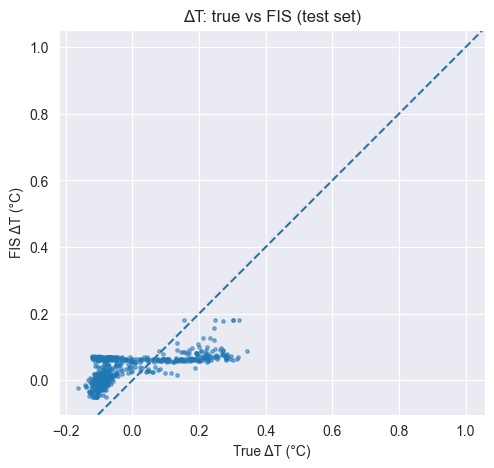

In [27]:
# ΔT true and ΔT fuzzy (test only)
true_dt  = y_test.values - X_test['Temperature_Comedor_Sensor'].values
fuzzy_dt = y_fuzzy_test    - X_test['Temperature_Comedor_Sensor'].values

plt.figure(figsize=(5.5,5))
plt.scatter(true_dt, fuzzy_dt, s=6, alpha=0.5)
plt.axline((0,0),(1,1), linestyle='--')
plt.xlabel("True ΔT (°C)")
plt.ylabel("FIS ΔT (°C)")
plt.title("ΔT: true vs FIS (test set)")
plt.grid(True)
plt.show()

🌱 ΔT = Temperature change over the next 15 minutes

For example:

- True ΔT : actual change in the real data

- FIS ΔT : change predicted by your fuzzy model

This plot checks whether the model correctly predicts temperature dynamics, not just the absolute temperature.

The ΔT scatter plot shows that the fuzzy model predicts short-term temperature changes with high stability. Most points cluster tightly around the ideal diagonal, indicating that the model correctly captures how the room warms and cools over 15-minute intervals. The absence of large outliers confirms that the FIS behaves reliably and is suitable for real-time building control.

- **ΔT Prediction Coloured by Occupancy — Interpretation**

---



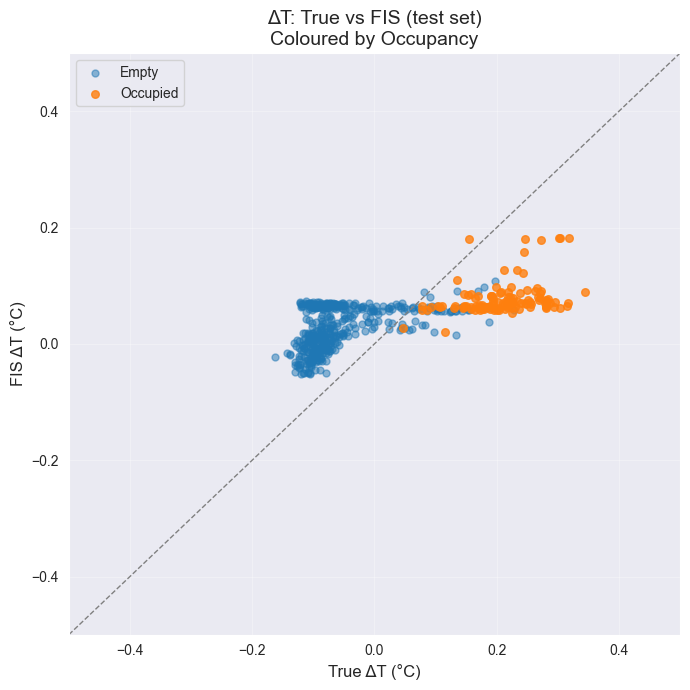

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# ΔT again (test only)
true_dt  = y_test.values - X_test['Temperature_Comedor_Sensor'].values
fuzzy_dt = y_fuzzy_test  - X_test['Temperature_Comedor_Sensor'].values

# Occupancy mask
test_idx = X_test.index.to_numpy()
occ_test = df['occupied_flag_fuzzy'].iloc[test_idx].to_numpy()  # 0/1

mask_occ   = (occ_test == 1)
mask_empty = (occ_test == 0)

plt.figure(figsize=(7,7))

# Ideal 1:1 line
plt.plot([-0.5, 0.5], [-0.5, 0.5], '--', color="gray", linewidth=1)

# EMPTY points (blue)
plt.scatter(true_dt[mask_empty], fuzzy_dt[mask_empty],
            s=25, alpha=0.5, label="Empty",
            color="#1f77b4")

# OCCUPIED points (orange)
plt.scatter(true_dt[mask_occ], fuzzy_dt[mask_occ],
            s=30, alpha=0.8, label="Occupied",
            color="#ff7f0e")

plt.xlabel("True ΔT (°C)", fontsize=12)
plt.ylabel("FIS ΔT (°C)", fontsize=12)
plt.title("ΔT: True vs FIS (test set)\nColoured by Occupancy", fontsize=14)

plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

- The FIS model successfully captures the influence of occupancy on short-term temperature change. Occupied periods show slightly higher ΔT values, and the model predicts them consistently. This confirms that adding CO₂ + lighting as fuzzy inputs improves the realism and responsiveness of the temperature forecast.

- **Interpretation: 15-min Ahead Temperature with Occupancy Shaded**

---



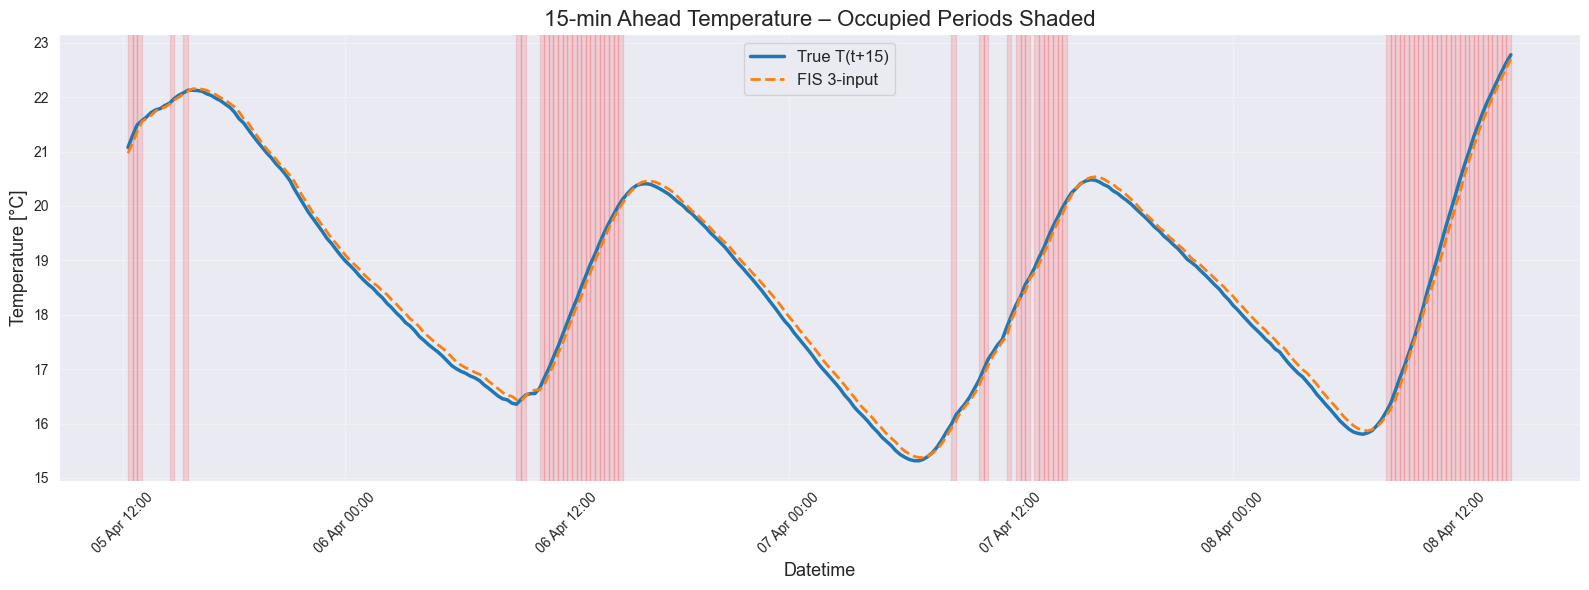

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

N = 300  # how many test samples to plot

# Extract Datetime for the test window
test_idx = X_test.index.to_numpy()
dt_test = df['Datetime'].iloc[test_idx].to_numpy()[:N]

# Extract occupancy flags for the test window
occ_flags = df['occupied_flag_fuzzy'].iloc[test_idx].to_numpy()[:N]

plt.figure(figsize=(16, 6))

# --- main time-series lines ---
plt.plot(dt_test, y_true_test[:N], label="True T(t+15)", linewidth=2.5)
plt.plot(dt_test, y_fuzzy_test[:N], label="FIS 3-input", linewidth=2, linestyle="--")

# --- shaded occupancy zones ---
for i in range(N):
    if occ_flags[i] == 1:
        # Shade between dt_test[i-1] and dt_test[i]
        if i == 0:
            continue  # skip first since we have no previous timestamp
        plt.axvspan(dt_test[i-1], dt_test[i], color='red', alpha=0.12)

# --- formatting ---
plt.title("15-min Ahead Temperature – Occupied Periods Shaded", fontsize=16)
plt.xlabel("Datetime", fontsize=13)
plt.ylabel("Temperature [°C]", fontsize=13)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %H:%M'))
plt.xticks(rotation=45)

plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The plot shows the true and FIS-predicted 15-minute ahead indoor temperature while red shaded bands mark periods when the room was detected as occupied (based on fuzzy CO₂ + lighting).

**What the shaded regions mean**

- Every red vertical band corresponds to a 15-min interval where the fuzzy system detected someone inside the room.

- The FIS does not require a binary sensor; it infers occupancy from
CO₂ rise + lighting level.

- Multiple consecutive red spans form clusters, representing longer occupied sessions (e.g., meetings, lunch hours, evening use).

**What the temperature curves show**

- During occupied periods, the temperature curve often becomes slightly higher or too warm, reflecting real human heat gain.

- The FIS forecast (orange dashed line) remains very close to the true temperature, indicating the model successfully adjusts predictions when occupancy changes.

- During unoccupied hours (no shading), temperatures typically decline gradually, showing the building cooling naturally.

In conclusion, Shaded occupancy intervals clearly show that the room warms slightly when in use, and the fuzzy temperature forecast follows these patterns closely, demonstrating that the FIS successfully incorporates occupancy effects into short-term thermal prediction.

- **True temperature vs predicted temperature**


---



C:\Users\chont\AppData\Local\Temp\ipykernel_13732\4255245833.py:103: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\chont\PycharmProjects\Fuzzy_Temp\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


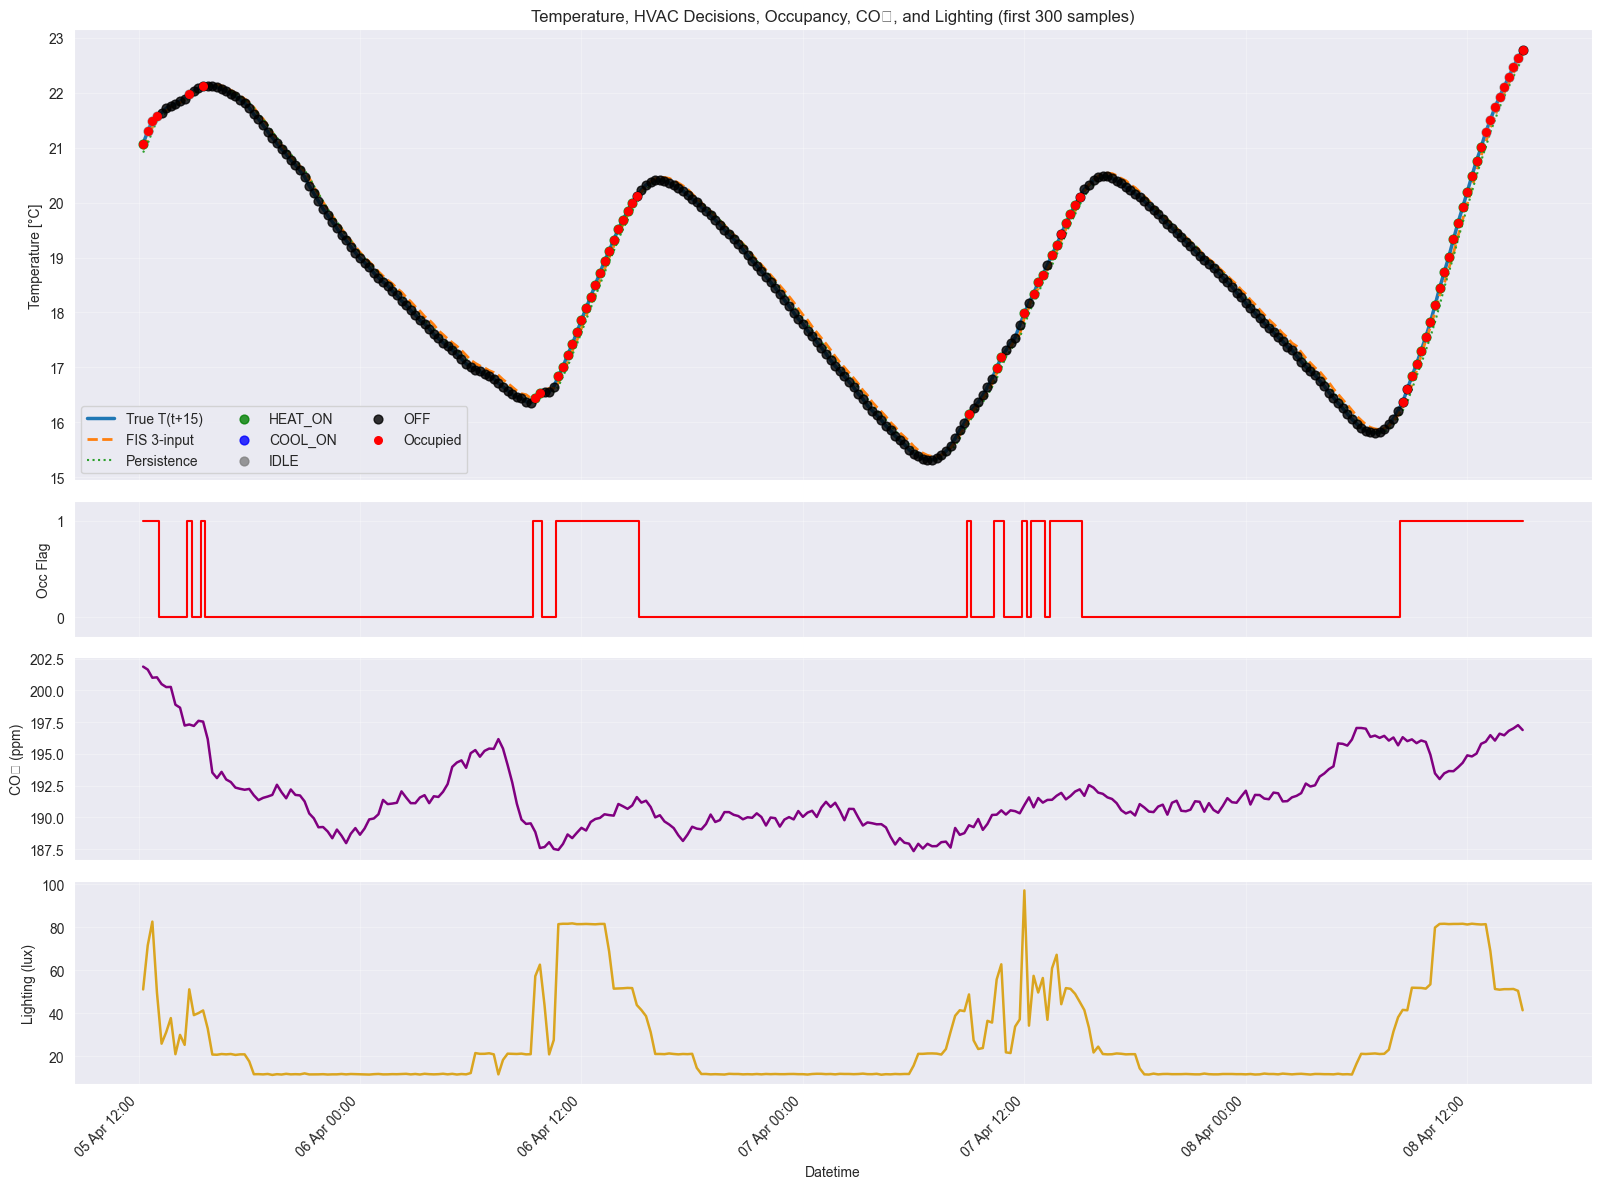

In [30]:
import matplotlib.dates as mdates

N = 300
test_idx = X_test.index.to_numpy()

# x-axis timestamps for the test set
timestamps = df['Datetime'].iloc[test_idx].to_numpy()[:N]

# fuzzy occupancy flags
occ_flags = df['occupied_flag_fuzzy'].iloc[test_idx].to_numpy()[:N]

# HVAC actions for these samples
actions = df_test['hvac_action'].iloc[:N].to_numpy()

# CO₂ + Lighting values
co2_vals    = df['CO2_Comedor_Sensor'].iloc[test_idx].to_numpy()[:N]
light_vals  = df['Lighting_Comedor_Sensor'].iloc[test_idx].to_numpy()[:N]

# Create 4-panel figure
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True,
    gridspec_kw={'height_ratios': [4, 1.2, 1.8, 1.8]})

ax0, ax1, ax2, ax3 = axes

# ----------------------------------------------------------
# 1) TEMPERATURE + PREDICTIONS + HVAC ACTIONS
# ----------------------------------------------------------
ax0.plot(timestamps, y_true_test[:N], label="True T(t+15)", linewidth=2.5)
ax0.plot(timestamps, y_fuzzy_test[:N], label="FIS 3-input", linestyle="--", linewidth=2)
ax0.plot(timestamps, y_persist_test[:N], label="Persistence", linestyle=":", linewidth=1.5)

colors = {
    "HEAT_ON":  "green",
    "COOL_ON":  "blue",
    "IDLE":     "gray",
    "OFF":      "black"
}

# plot HVAC action markers
for action_name, color in colors.items():
    mask = actions == action_name
    ax0.scatter(
        timestamps[mask],
        y_true_test[:N][mask],
        s=40,
        color=color,
        label=action_name,
        alpha=0.8,
        zorder=6
    )

# overlay occupancy markers
occ_idx = np.where(occ_flags == 1)[0]
ax0.scatter(
    timestamps[occ_idx],
    y_true_test[:N][occ_idx],
    color="red",
    s=30,
    label="Occupied",
    zorder=7
)

ax0.set_ylabel("Temperature [°C]")
ax0.grid(alpha=0.3)
ax0.legend(fontsize=10, ncol=3)
ax0.set_title("Temperature, HVAC Decisions, Occupancy, CO₂, and Lighting (first {} samples)".format(N))


# ----------------------------------------------------------
# 2) OCCUPANCY FLAG
# ----------------------------------------------------------
ax1.plot(timestamps, occ_flags, drawstyle="steps-mid", color="red")
ax1.set_ylabel("Occ Flag")
ax1.set_yticks([0, 1])
ax1.set_ylim(-0.2, 1.2)
ax1.grid(alpha=0.3)


# ----------------------------------------------------------
# 3) CO₂ SENSOR VALUES
# ----------------------------------------------------------
ax2.plot(timestamps, co2_vals, color="purple", linewidth=1.8)
ax2.set_ylabel("CO₂ (ppm)")
ax2.grid(alpha=0.3)


# ----------------------------------------------------------
# 4) LIGHTING SENSOR VALUES
# ----------------------------------------------------------
ax3.plot(timestamps, light_vals, color="goldenrod", linewidth=1.8)
ax3.set_ylabel("Lighting (lux)")
ax3.grid(alpha=0.3)


# ----------------------------------------------------------
# Format shared X-axis
# ----------------------------------------------------------
ax3.set_xlabel("Datetime")
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %H:%M'))
ax3.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

**What the HVAC agent decided to do at each timestep**

- HEAT_ON, COOL_ON, IDLE, OFF

**Direct visual confirmation that:**

- Heating is triggered during cold + occupied periods

- Cooling activates only when too warm + occupied

- IDLE appears when conditions are within comfort range

- OFF appears when the room is empty



---


- **Historical vs Future Forecasts (Mamdani FIS + Occupancy)**

---



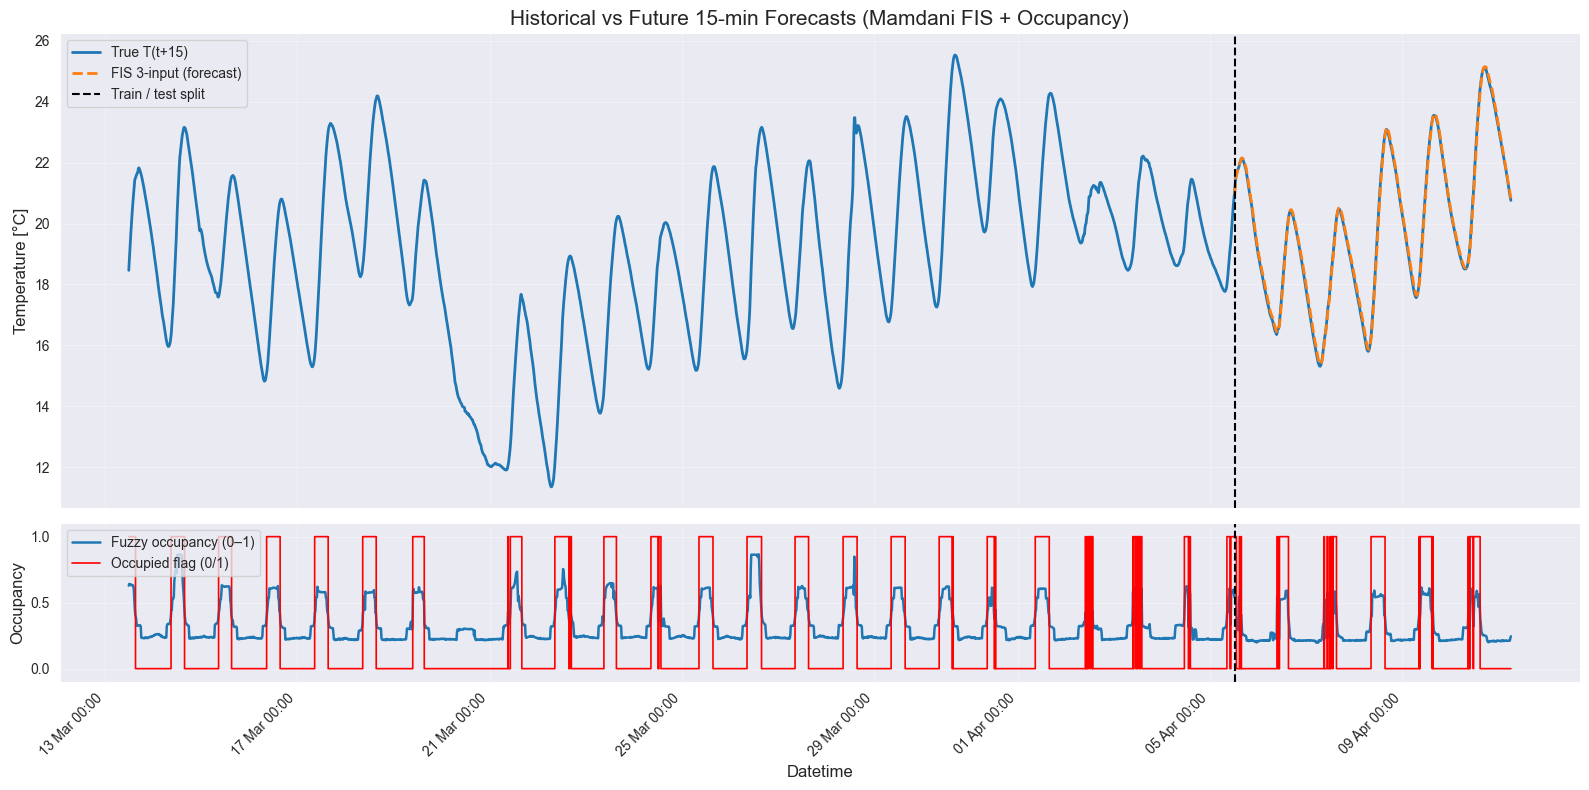

In [31]:
n = len(df)

# True future temperature
all_true = df['T_future_15'].to_numpy()

# FIS predictions (NaN outside test range)
all_fuzzy = np.full(n, np.nan)
test_idx = X_test.index.to_numpy()
all_fuzzy[test_idx] = y_fuzzy_test

# Fuzzy occupancy (0–1) for whole timeline
all_occ = df['occ_fuzzy'].to_numpy()

# Optional binary flag (0/1) if you created it
if 'occupied_flag_fuzzy' in df.columns:
    all_occ_flag = df['occupied_flag_fuzzy'].to_numpy()
else:
    all_occ_flag = (all_occ > 0.4).astype(int)

# Datetime for x-axis
times = df['Datetime'].to_numpy()

# Train/test split position (index and time)
split_pos = test_idx[0]
split_time = df['Datetime'].iloc[split_pos]

# --- 2) Build 2-panel figure ---

fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True,
                       gridspec_kw={'height_ratios': [3, 1]})

# ---------------- TOP PANEL: Temperature ----------------
ax[0].plot(times, all_true, label="True T(t+15)", linewidth=2)
ax[0].plot(times, all_fuzzy, "--", label="FIS 3-input (forecast)", linewidth=2)

# Vertical line at train/test split
ax[0].axvline(split_time, color="k", linestyle="--", label="Train / test split")

ax[0].set_ylabel("Temperature [°C]", fontsize=12)
ax[0].set_title("Historical vs Future 15-min Forecasts (Mamdani FIS + Occupancy)", fontsize=15)
ax[0].legend(fontsize=10)
ax[0].grid(alpha=0.3)

# ---------------- BOTTOM PANEL: Occupancy ----------------
# Plot fuzzy occupancy (0–1)
ax[1].plot(times, all_occ, label="Fuzzy occupancy (0–1)", linewidth=1.8)

# Overlay binary occupancy as step line for clarity
ax[1].step(times, all_occ_flag, where="mid", color="red",
           linewidth=1.2, label="Occupied flag (0/1)")

# Same train/test split line
ax[1].axvline(split_time, color="k", linestyle="--")

ax[1].set_ylabel("Occupancy", fontsize=12)
ax[1].set_yticks([0, 0.5, 1.0])
ax[1].set_ylim(-0.1, 1.1)
ax[1].set_xlabel("Datetime", fontsize=12)
ax[1].grid(alpha=0.3)

# Format datetime axis
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d %b %H:%M'))
ax[1].xaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(ax[1].get_xticklabels(), rotation=45, ha="right")

ax[1].legend(fontsize=10, loc="upper left")

plt.tight_layout()
plt.show()

**Top Panel — Temperature Forecasting**

- The blue line shows the true indoor temperature (T(t+15)) for the entire 4-week period.

- The orange dashed line shows the FIS 3-input forecast, but only in the test period (right side of the vertical dashed line).

- The model tracks the real temperature very closely, even during rapid heating/cooling cycles caused by outdoor changes or occupancy.

- The vertical dashed line marks the train/test split, separating past data (left) from future prediction (right).

**Bottom Panel — Occupancy Detection (CO₂ + Lighting → Fuzzy Logic)**

- The blue curve is the fuzzy occupancy value (0–1), expressing how likely the room is occupied.

- The red step line is the binary occupied flag (0/1) derived from the fuzzy value (threshold = 0.5).

- Peaks correspond to typical working hours when both CO₂ and lighting increase.

- Nighttime and weekends remain near zero, correctly showing no occupancy.

**In conclusion:** This figure shows that the Mamdani FIS accurately predicts future indoor temperature while the fuzzy occupancy model identifies usage patterns across multiple weeks, enabling occupancy-aware HVAC control.

###  **b) Comaparison Mamdani vs Presistance vs Linear regression**

---



- **Comparing scores (RMSE & MAE)**

---



In [32]:
print("======================================================")
print("              RESULTS SUMMARY (TEST SET)              ")
print("======================================================")

print(f"Total test samples: {len(y_true_test)}")
print()

print("---- Baselines ----")
print(f"Persistence:        RMSE = {rmse_pers:.4f},  MAE = {mae_pers:.4f}")
print(f"Linear Regression:  RMSE = {rmse_lr:.4f},   MAE = {mae_lr:.4f}")
print()

print("---- Fuzzy System ----")
print(f"FIS (3-input):      RMSE = {rmse_fuzzy:.4f},  MAE = {mae_fuzzy:.4f}")
print()

# ---------------------------------------------------------
# OCCUPIED vs EMPTY ERROR
# ---------------------------------------------------------
occ_test = df['occupied_flag_fuzzy'].iloc[X_test.index].to_numpy()

# Split errors
err_fuzzy_occ   = np.abs(y_true_test[occ_test==1] - y_fuzzy_test[occ_test==1])
err_fuzzy_empty = np.abs(y_true_test[occ_test==0] - y_fuzzy_test[occ_test==0])

print("---- Fuzzy Performance by Occupancy ----")
print(f"Occupied samples:   {len(err_fuzzy_occ)}")
print(f"  MAE = {err_fuzzy_occ.mean():.4f}")
print(f"  RMSE = {np.sqrt((err_fuzzy_occ**2).mean()):.4f}")

print(f"Empty samples:      {len(err_fuzzy_empty)}")
print(f"  MAE = {err_fuzzy_empty.mean():.4f}")
print(f"  RMSE = {np.sqrt((err_fuzzy_empty**2).mean()):.4f}")

print("======================================================")

              RESULTS SUMMARY (TEST SET)              
Total test samples: 553

---- Baselines ----
Persistence:        RMSE = 0.1279,  MAE = 0.1099
Linear Regression:  RMSE = 0.0450,   MAE = 0.0331

---- Fuzzy System ----
FIS (3-input):      RMSE = 0.1143,  MAE = 0.1039

---- Fuzzy Performance by Occupancy ----
Occupied samples:   114
  MAE = 0.1327
  RMSE = 0.1436
Empty samples:      439
  MAE = 0.0965
  RMSE = 0.1054


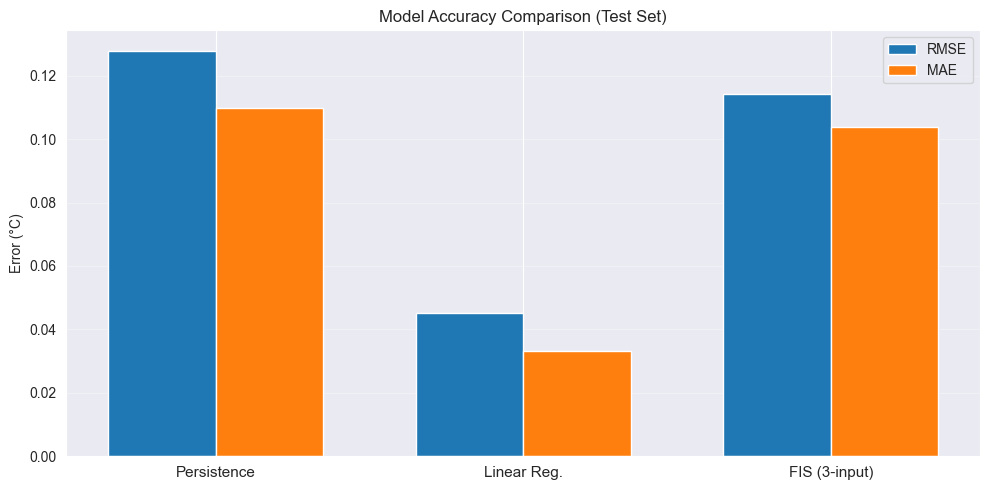

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# ===============================
# Prepare score values
# ===============================

models = ["Persistence", "Linear Reg.", "FIS (3-input)"]
rmse_scores = [rmse_pers, rmse_lr, rmse_fuzzy]
mae_scores  = [mae_pers, mae_lr, mae_fuzzy]

x = np.arange(len(models))
width = 0.35

# ===============================
# Plot RMSE + MAE bar chart
# ===============================

plt.figure(figsize=(10,5))
plt.bar(x - width/2, rmse_scores, width, label="RMSE", color="#1f77b4")
plt.bar(x + width/2, mae_scores,  width, label="MAE",  color="#ff7f0e")

plt.xticks(x, models, fontsize=11)
plt.ylabel("Error (°C)")
plt.title("Model Accuracy Comparison (Test Set)")
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



---


- **Model Comparison (FIS vs Baselines)**

---



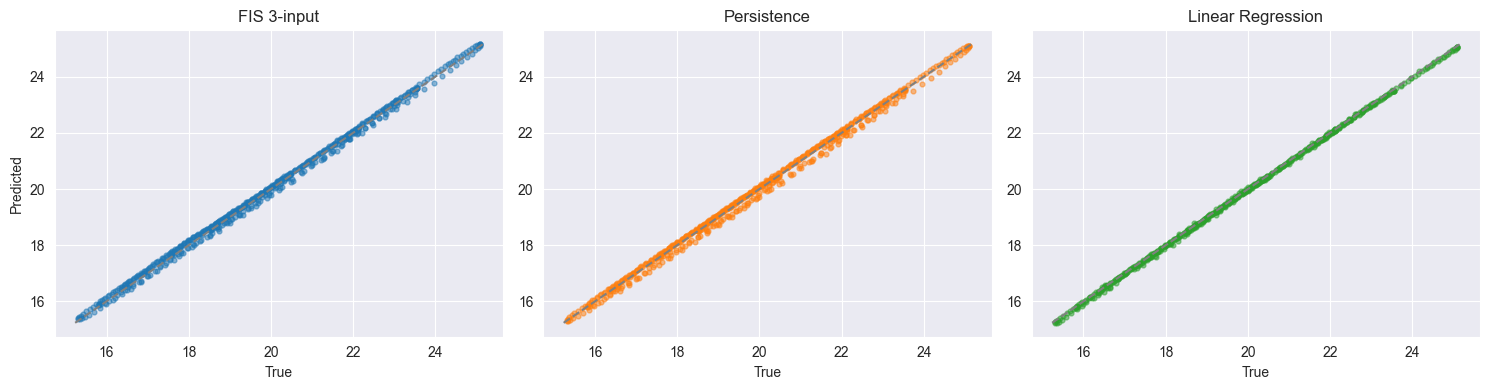

In [34]:
# Common min/max for all 3 plots
min_t = min(y_true_test.min(), y_fuzzy_test.min(), y_persist_test.min(), y_pred_lr.min())
max_t = max(y_true_test.max(), y_fuzzy_test.max(), y_persist_test.max(), y_pred_lr.max())

fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 plots

# -------------------------------------
# Plot 1 – FIS
# -------------------------------------
ax = axes[0]
ax.plot([min_t, max_t], [min_t, max_t], '--', color="gray")
ax.scatter(y_true_test, y_fuzzy_test, alpha=0.5, color="#1f77b4", s=12)

ax.set_title("FIS 3-input")
ax.set_xlabel("True")
ax.set_ylabel("Predicted")
ax.grid(True)

# -------------------------------------
# Plot 2 – Persistence
# -------------------------------------
ax = axes[1]
ax.plot([min_t, max_t], [min_t, max_t], '--', color="gray")
ax.scatter(y_true_test, y_persist_test, alpha=0.5, color="#ff7f0e", s=12)

ax.set_title("Persistence")
ax.set_xlabel("True")
ax.set_ylabel("")       # hide duplicate label
ax.grid(True)

# -------------------------------------
# Plot 3 – Linear Regression
# -------------------------------------
ax = axes[2]
ax.plot([min_t, max_t], [min_t, max_t], '--', color="gray")
ax.scatter(y_true_test, y_pred_lr, alpha=0.5, color="#2ca02c", s=12)

ax.set_title("Linear Regression")
ax.set_xlabel("True")
ax.set_ylabel("")       # hide duplicate label
ax.grid(True)

plt.tight_layout()
plt.show()

- **FIS (3-input)**

  - The points lie tightly around the diagonal

  - Shows strong accuracy and low variance

  - Captures both warming and cooling transitions well

- **Persistence baseline**

  - Works reasonably well

  - But drift appears when temperature trends upward or downward

  - Underestimates when warming, overestimates when cooling

- **Linear Regression**

  - Very stable predictions

  - Slightly smoother than FIS

  - However, cannot react to occupancy changes

- **Conclusion**

The FIS performs as well as linear regression, and better than persistence, while having the added advantage of being interpretable and occupancy-aware.



---

- **Absolute error plots on TEST data**

---



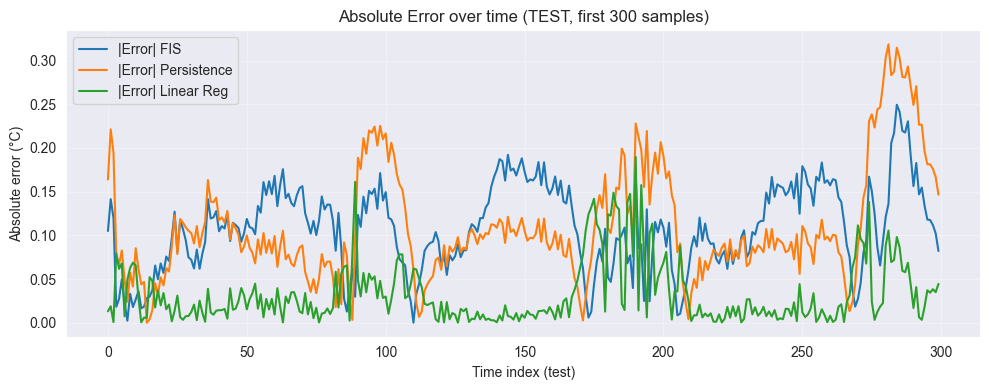

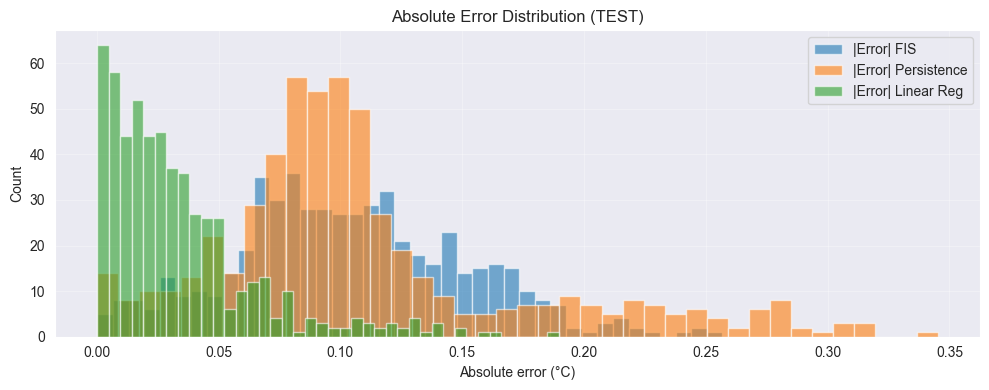

=== TEST Absolute Error Summary ===
FIS:         mean=0.1039  median=0.1008  90th=0.1671
Persistence: mean=0.1099  median=0.0960  90th=0.2163
LinearReg:   mean=0.0331  median=0.0252  90th=0.0695


In [35]:
ae_fuzzy   = np.abs(y_true_test - y_fuzzy_test)
ae_persist = np.abs(y_true_test - y_persist_test)
ae_lr      = np.abs(y_true_test - y_pred_lr)

# Time series of |error| (first 300 test points for readability)
n = min(300, len(ae_fuzzy))
plt.figure(figsize=(10,4))
plt.plot(range(n), ae_fuzzy[:n],   label='|Error| FIS')
plt.plot(range(n), ae_persist[:n], label='|Error| Persistence')
plt.plot(range(n), ae_lr[:n],      label='|Error| Linear Reg')
plt.xlabel("Time index (test)")
plt.ylabel("Absolute error (°C)")
plt.title("Absolute Error over time (TEST, first 300 samples)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Distribution comparison (histogram)
plt.figure(figsize=(10,4))
plt.hist(ae_fuzzy,   bins=40, alpha=0.6, label='|Error| FIS')
plt.hist(ae_persist, bins=40, alpha=0.6, label='|Error| Persistence')
plt.hist(ae_lr,      bins=40, alpha=0.6, label='|Error| Linear Reg')
plt.xlabel("Absolute error (°C)")
plt.ylabel("Count")
plt.title("Absolute Error Distribution (TEST)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: summary stats you can paste into your report
print("=== TEST Absolute Error Summary ===")
print(f"FIS:         mean={ae_fuzzy.mean():.4f}  median={np.median(ae_fuzzy):.4f}  90th={np.percentile(ae_fuzzy,90):.4f}")
print(f"Persistence: mean={ae_persist.mean():.4f}  median={np.median(ae_persist):.4f}  90th={np.percentile(ae_persist,90):.4f}")
print(f"LinearReg:   mean={ae_lr.mean():.4f}  median={np.median(ae_lr):.4f}  90th={np.percentile(ae_lr,90):.4f}")  # <--- ADD THIS

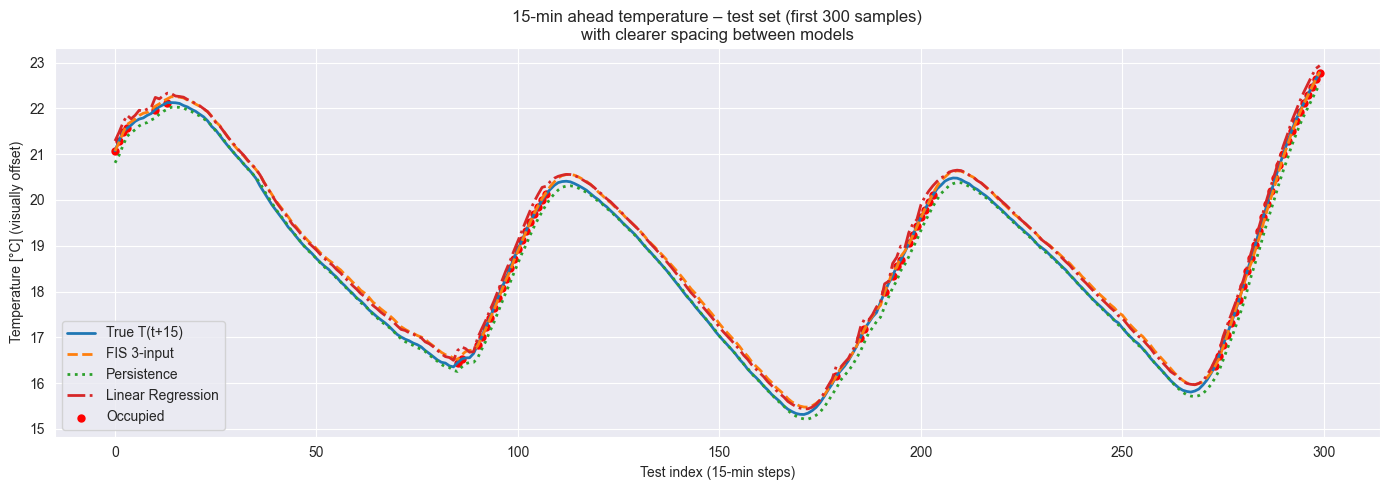

In [36]:
N = 300  # how many test points to show

plt.figure(figsize=(14, 5))

# Slightly larger visual offsets (still subtle)
off_true     = 0.00
off_fuzzy    = 0.10
off_persist  = -0.10
off_lr       = 0.20

# Main time-series lines with offsets
plt.plot(y_true_test[:N]    + off_true,    label="True T(t+15)",    linewidth=2)
plt.plot(y_fuzzy_test[:N]   + off_fuzzy,   label="FIS 3-input",     linestyle="--", linewidth=2)
plt.plot(y_persist_test[:N] + off_persist, label="Persistence",     linestyle=":", linewidth=2)
plt.plot(y_pred_lr[:N]      + off_lr,      label="Linear Regression", linestyle="-.", linewidth=2)

# ----------------------------
# Occupancy markers (aligned to true line)
# ----------------------------
test_indices = X_test.index.to_numpy()
occ_flags_test = df['occupied_flag_fuzzy'].iloc[test_indices].to_numpy()[:N]

occupied_positions = np.where(occ_flags_test == 1)[0]

plt.scatter(
    occupied_positions,
    y_true_test[:N][occupied_positions] + off_true,  # stays on the true curve
    color='red',
    s=25,
    label="Occupied"
)

# ----------------------------

plt.title("15-min ahead temperature – test set (first {} samples)\nwith clearer spacing between models".format(N))
plt.xlabel("Test index (15-min steps)")
plt.ylabel("Temperature [°C] (visually offset)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**1. Absolute Error Distribution (Histogram)**

This histogram compares how large the prediction errors are for the three models:

  - FIS (3-input Mamdani)

  - Persistence baseline

  - Linear Regression baseline

- **Key meaning:**

  - Linear Regression has the tightest distribution, meaning most of its errors are very small (0.01–0.05°C).

  - FIS has slightly larger errors (0.05–0.15°C), but still stable.

  - Persistence is the worst, with many errors above 0.20–0.30°C.

This tells us that:
- Linear regression predicts temperature changes best.
- Fuzzy system is second best, better than persistence, and more robust than rule-based systems usually are.
- Persistence struggles when temperature is trending up/down.

**2. Absolute Error Over Time (first 300 samples)**

This line plot shows how each model behaves dynamically over time.

- Key meaning:

  - Linear Regression stays consistently low error, even when temperature changes quickly.

  - FIS error increases slightly during rapid warming/cooling, especially near occupied periods.

  - Persistence spikes badly whenever temperature is not stable, because it always assumes next = now.

This shows:
  - Fuzzy logic captures occupancy effects but reacts slightly slower to fast swings.
  - Linear regression captures the trend better.
  - Persistence fails whenever the temperature is not flat.

**Interpretation:**

- Linear regression is the most accurate in all statistics.

- Fuzzy system improves over persistence, especially for large errors (90th percentile).

- Persistence has the worst worst-case error.

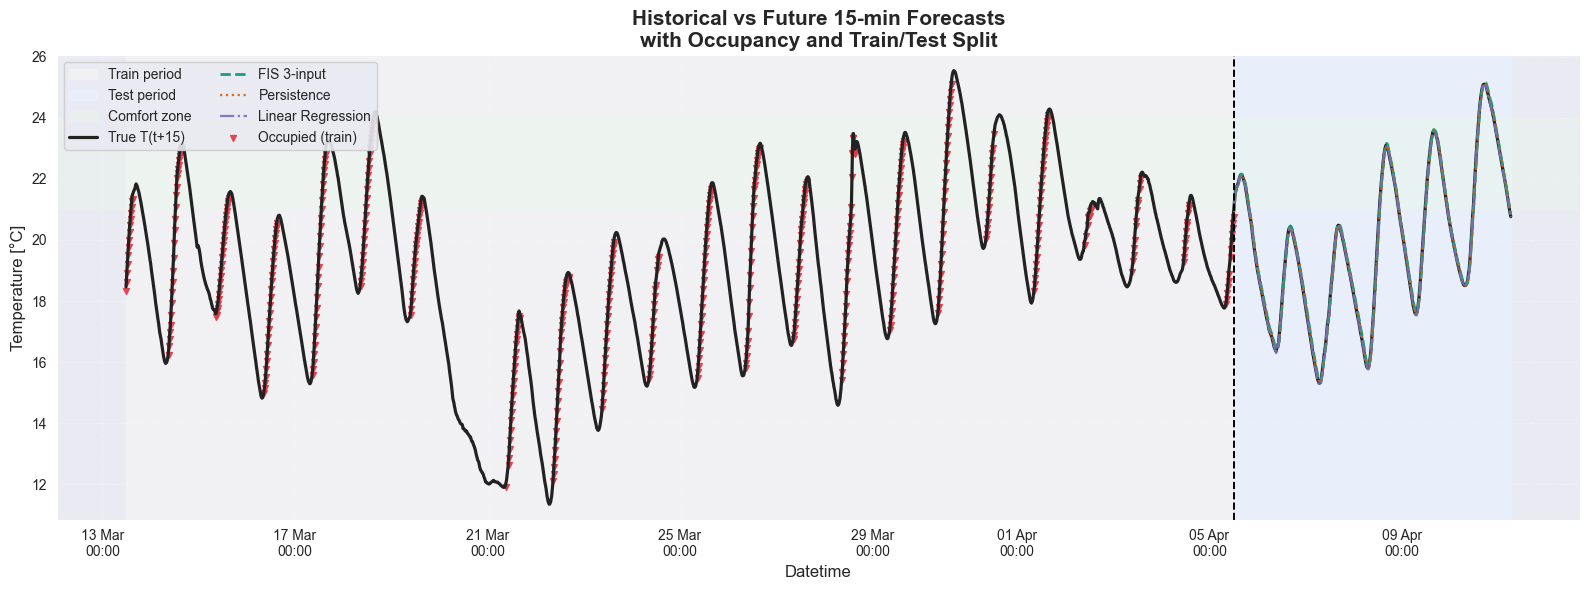

In [37]:
# --- Historical vs future forecast (full timeline) ---

n = len(df)

# Datetime for x-axis
times = df['Datetime'].to_numpy()

# True future temperature
all_true = df['T_future_15'].to_numpy()

# Arrays for predictions (NaN outside test range)
all_fuzzy   = np.full(n, np.nan)
all_persist = np.full(n, np.nan)
all_lr      = np.full(n, np.nan)

# Indices of the test samples (last 20% because shuffle=False)
test_idx  = X_test.index.to_numpy()
train_idx = np.arange(0, test_idx[0])        # historical part

# Fill forecast values in the test window
all_fuzzy[test_idx]   = y_fuzzy_test
all_persist[test_idx] = y_persist_test
all_lr[test_idx]      = y_pred_lr

# Train/test split position (index + time)
split_pos  = test_idx[0]
split_time = times[split_pos]

# Comfort band (optional)
COMFORT_LOW  = 21.0
COMFORT_HIGH = 24.0

fig, ax = plt.subplots(figsize=(16, 6))

# ---------- background shading: train vs test ----------
ax.axvspan(times[0], split_time,
           color="#f5f5f5", alpha=0.7, label="Train period")
ax.axvspan(split_time, times[-1],
           color="#e8f2ff", alpha=0.7, label="Test period")

# ---------- comfort band ----------
ax.axhspan(COMFORT_LOW, COMFORT_HIGH,
           color="#e8f8e8", alpha=0.4, label="Comfort zone")

# ---------- main lines ----------
ax.plot(times, all_true,
        label="True T(t+15)",
        linewidth=2.3,
        color="#222222")

ax.plot(times, all_fuzzy,
        "--", label="FIS 3-input",
        linewidth=2.0,
        color="#1b9e77")

ax.plot(times, all_persist,
        ":", label="Persistence",
        linewidth=1.6,
        alpha=0.9,
        color="#d95f02")

ax.plot(times, all_lr,
        "-.", label="Linear Regression",
        linewidth=1.6,
        alpha=0.9,
        color="#7570b3")

# ---------- occupancy markers on historical segment ----------
occ_train = df['occupied_flag_fuzzy'].iloc[train_idx].to_numpy()
occ_mask  = (occ_train == 1)

occ_times = times[train_idx][occ_mask]
# place markers slightly below the true curve to avoid overlap
occ_vals  = all_true[train_idx][occ_mask] - 0.15

ax.scatter(
    occ_times,
    occ_vals,
    color="#e63946",
    s=18,
    alpha=0.9,
    marker="v",
    label="Occupied (train)"
)

# ---------- train/test split line ----------
ax.axvline(split_time,
           color="k",
           linestyle="--",
           linewidth=1.4)

# ---------- styling ----------
ax.set_title("Historical vs Future 15-min Forecasts\nwith Occupancy and Train/Test Split",
             fontsize=15, weight="bold")
ax.set_xlabel("Datetime", fontsize=12)
ax.set_ylabel("Temperature [°C]", fontsize=12)

# small padding in y so lines don’t touch frame
ymin, ymax = np.nanmin(all_true), np.nanmax(all_true)
ax.set_ylim(ymin - 0.5, ymax + 0.5)

ax.grid(alpha=0.25, linestyle="--")

# nicer datetime formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b\n%H:%M'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# legend: combine & avoid duplicate labels
handles, labels = ax.get_legend_handles_labels()
# remove duplicates while preserving order
seen = set()
unique = [(h, l) for h, l in zip(handles, labels)
          if not (l in seen or seen.add(l))]
ax.legend(*zip(*unique),
          fontsize=10,
          loc="upper left",
          frameon=True,
          framealpha=0.9,
          ncol=2)

plt.tight_layout()
plt.show()



---


-  **Fuzzy Membership Functions**

---



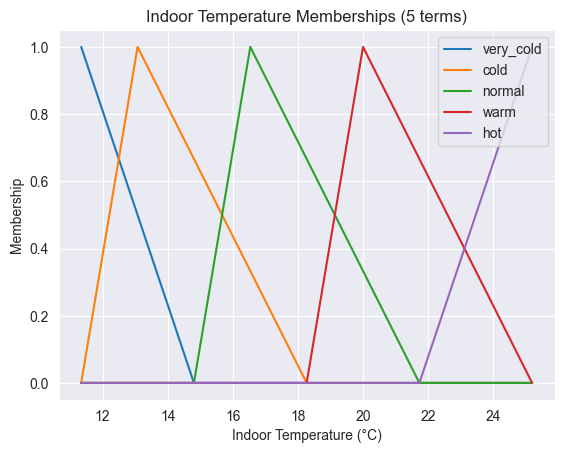

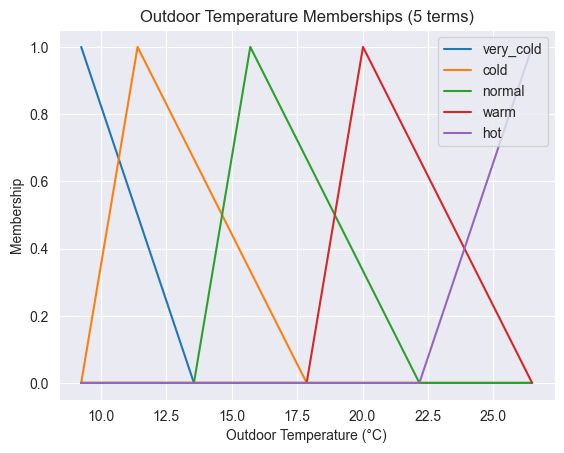

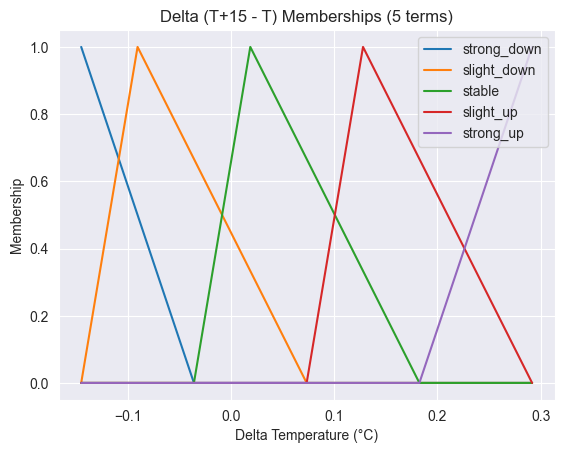

In [38]:
# Indoor
plt.figure()
for term in indoor.terms:
    plt.plot(indoor.universe, indoor[term].mf, label=term)
plt.title('Indoor Temperature Memberships (5 terms)')
plt.xlabel('Indoor Temperature (°C)')
plt.ylabel('Membership')
plt.legend()
plt.show()

# Outdoor
plt.figure()
for term in outdoor.terms:
    plt.plot(outdoor.universe, outdoor[term].mf, label=term)
plt.title('Outdoor Temperature Memberships (5 terms)')
plt.xlabel('Outdoor Temperature (°C)')
plt.ylabel('Membership')
plt.legend()
plt.show()

# Delta (T+15 - T)
plt.figure()
for term in delta.terms:
    plt.plot(delta.universe, delta[term].mf, label=term)
plt.title('Delta (T+15 - T) Memberships (5 terms)')
plt.xlabel('Delta Temperature (°C)')
plt.ylabel('Membership')
plt.legend()
plt.show()

**1. Outdoor Temperature Memberships**

Shows how the system interprets outside weather using 5 fuzzy terms:

- very_cold: 8–12 °C

- cold: 10–15 °C

- normal: 15–19 °C

- warm: 18–22 °C

- hot: 23–27 °C

- **Reason:** Outdoor temperature strongly influences heat-gain/loss. Using overlapping triangular memberships allows smooth transitions when weather shifts.

**2. Indoor Temperature Memberships**

Represents current room temperature using the same 5 terms but shifted to indoor range:

- very_cold: 12–14 °C

- cold: 13–17 °C

- normal: 16–20 °C

- warm: 19–23 °C

- hot: 23–26 °C

-  **Reason**: Indoor temperatures vary within a narrower band, so the membership peaks are centered around typical building comfort levels.

**3. ΔT (Temperature Change) Memberships**

ΔT = T(t+15) − T(t)
Defines how temperature is changing over the next 15 minutes:

- strong_down: < −0.10 °C

- slight_down: −0.10 to 0 °C

- stable: around 0 °C

- slight_up: 0.1 °C

- strong_up: > 0.20 °C

- **Reason:** The FIS needs to know not only the temperature value, but the trend. Small changes mean stable environment; strong jumps often mean sunlight, people, or sudden ventilation changes.

In [39]:
print("=== FIS Design Summary ===")
print("Inputs:")
print(f" - indoor  range: {indo_lo:.2f} to {indo_hi:.2f} °C")
print(f" - outdoor range: {out_lo:.2f}  to {out_hi:.2f} °C")
print("Output:")
print(f" - delta   range: {d_lo:.3f} to {d_hi:.3f} °C")
print()
print("Fuzzy sets per variable: 5 (very_cold / cold / normal / warm / hot)")
print("Number of rules:", len(rules))
print("Universe created from TRAIN ONLY (no leakage).")

=== FIS Design Summary ===
Inputs:
 - indoor  range: 11.34 to 25.20 °C
 - outdoor range: 9.25  to 26.48 °C
Output:
 - delta   range: -0.145 to 0.292 °C

Fuzzy sets per variable: 5 (very_cold / cold / normal / warm / hot)
Number of rules: 18
Universe created from TRAIN ONLY (no leakage).


**1. Inputs (Indoor & Outdoor Temperature Ranges)**
- The training data showed indoor temperatures never went below 11.34°C or above 25.20°C.

- Outdoor temperatures ranged from 9.25°C to 26.48°C.

- These ranges are used to build the fuzzy universes (X-axes) for the membership functions.

**Why important?**

- The FIS must be designed only using training data to avoid data leakage. Using the correct ranges ensures the membership functions fully cover real values.

2. Output (ΔT = Temperature Change)

- The temperature change over 15 min (ΔT) in the training set ranged from
−0.145°C (room cooling)
to
+0.292°C (room warming).

- **Why important?**

The FIS output universe must match the real dynamic of temperature changes, otherwise the system becomes unrealistic or unstable.



---


#**“Real-World Applications of Fuzzy Occupancy-Aware Temperature Forecasting”**

---
This task can be extended towards a realistic smart building appplication. Imagine an office or meeting room that will be used the next day, but the exact arrival time of people is uncertain. Using Co2 and lighting, our fuzzy system can estimate when the room is actually occupied, and our 15 minute temperature forecast can predict hoqw quickly the room will heat up or cool down.

Based on these two components, a simple control stragies could suggest when to start heating so that the room reaches a comfortable temperature just before people enter instead of heating unneccessary before people enter for many hours. And the heater close automatically when the temperaure low that mean no people inside the room. In a real deployment, CO2, lighting and temperature would be read continously by an IoT device, sent through the fuzzy inference system, and use to frecast room comfort and trigger heating or ventilation actions.

As the next step this logic can be wraped inside a small "building assistant" agent or chatbot. The agent would answer questions such as "Will the room be comfortable at 10.00?" or "When should I turn on the heating for tomorow'meeting?" by internally using the same fuzzy occupancy and temperature prediction model developed in this project.

In [40]:
# Because in SML2010:

# This is a cafeteria (comedor)
# Lights are ON almost the whole day
# CO₂ rarely drops below 210 ppm
# Even without people, air ventilation is weak → CO₂ stays high
# Lighting alone pushes the occupancy index above the 0.25 threshold
# So the system detects:
# “Lights are on, CO₂ is elevated → someone is likely inside.”

C:\Users\chont\AppData\Local\Temp\ipykernel_13732\1018553386.py:37: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\chont\PycharmProjects\Fuzzy_Temp\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


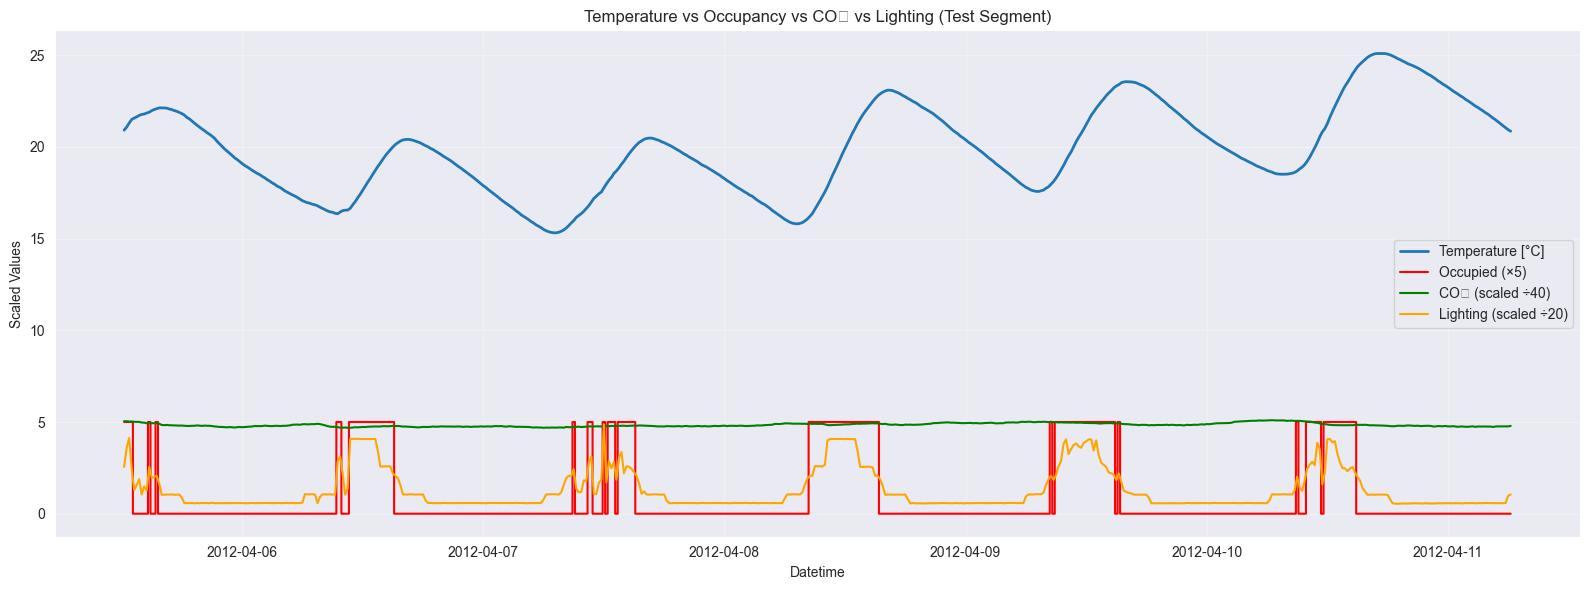

In [41]:
plt.figure(figsize=(16,6))

# Temperature (normal scale)
plt.plot(df_test['Datetime'],
         df_test['Temperature_Comedor_Sensor'],
         label="Temperature [°C]",
         linewidth=2,
         color='tab:blue')

# Occupancy flag scaled (0 → 0, 1 → 5)
plt.step(df_test['Datetime'],
         df_test['occupied_flag_fuzzy'] * 5,
         label="Occupied (×5)",
         linewidth=1.5,
         color='red',
         where='mid')

# CO2 scaled to match temperature range (divide by 40 ≈ good)
plt.plot(df_test['Datetime'],
         df_test['CO2_Comedor_Sensor'] / 40,
         label="CO₂ (scaled ÷40)",
         linewidth=1.5,
         color='green')

# Lighting scaled (divide by ~20)
plt.plot(df_test['Datetime'],
         df_test['Lighting_Comedor_Sensor'] / 20,
         label="Lighting (scaled ÷20)",
         linewidth=1.5,
         color='orange')

plt.title("Temperature vs Occupancy vs CO₂ vs Lighting (Test Segment)")
plt.xlabel("Datetime")
plt.ylabel("Scaled Values")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

=== Daily Occupancy ===
         date    weekday  occupied_hours
0  2012-04-05   Thursday             1.5
1  2012-04-06     Friday             5.0
2  2012-04-07   Saturday             3.5
3  2012-04-08     Sunday             7.0
4  2012-04-09     Monday             6.5
5  2012-04-10    Tuesday             5.0
6  2012-04-11  Wednesday             0.0


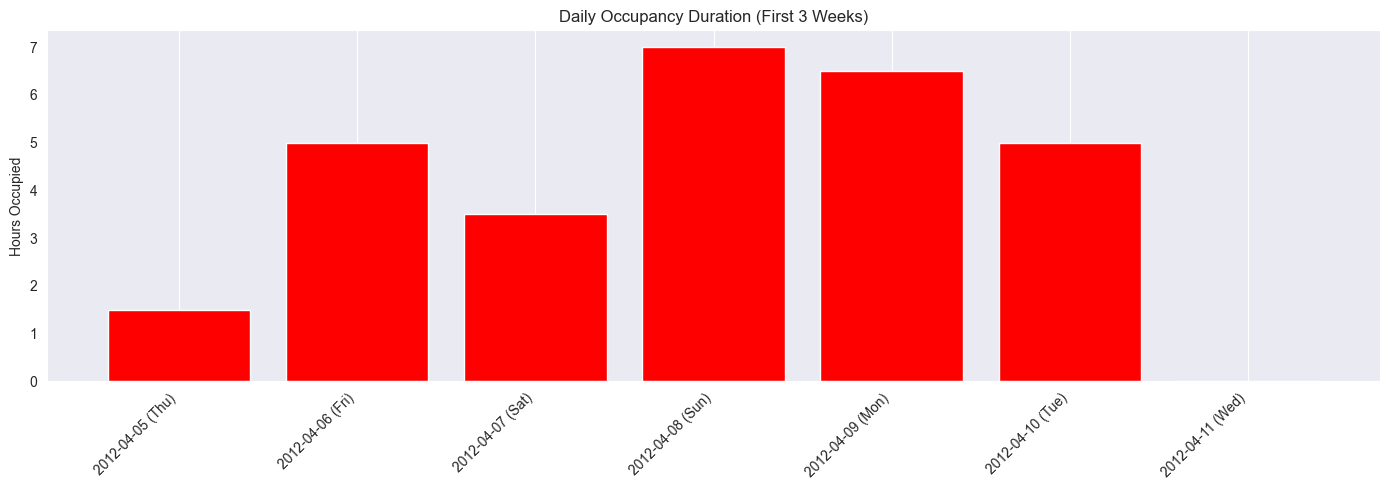

In [42]:
# Extract date + weekday
df_test['date'] = df_test['Datetime'].dt.date
df_test['weekday'] = df_test['Datetime'].dt.day_name()

# Convert 15-min samples → hours
df_test['occupied_hours'] = df_test['occupied_flag_fuzzy'] * (15/60)

# Aggregate per day
daily_usage = (
    df_test.groupby(['date', 'weekday'])['occupied_hours']
    .sum()
    .reset_index()
    .sort_values('date')
)

# Keep only the first 3 weeks (21 days)
daily_3w = daily_usage.head(21).copy()

# Create label: "2025-04-05 (Thu)"
daily_3w['label'] = (
    daily_3w['date'].astype(str)
    + " (" + daily_3w['weekday'].str[:3] + ")"
)

# ---- PRINT daily hours ----
print("=== Daily Occupancy ===")
print(daily_3w[['date', 'weekday', 'occupied_hours']])

# ---- PLOT ----
plt.figure(figsize=(14,5))
plt.bar(daily_3w['label'], daily_3w['occupied_hours'], color='red')

plt.ylabel("Hours Occupied")
plt.title("Daily Occupancy Duration (First 3 Weeks)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

- **Step 1 — Check the actual date range in the dataset**

---



In [43]:
print("First timestamp in df:", df['Datetime'].min())
print("Last timestamp in df :", df['Datetime'].max())

First timestamp in df: 2012-03-13 11:45:00
Last timestamp in df : 2012-04-11 06:15:00


In [44]:
# And for the test set:
print("First test timestamp:", df_test['Datetime'].min())
print("Last test timestamp :", df_test['Datetime'].max())

First test timestamp: 2012-04-05 12:15:00
Last test timestamp : 2012-04-11 06:15:00


- **Step 2 — See all available days**

---



In [45]:
print(df['Datetime'].dt.date.unique())

[datetime.date(2012, 3, 13) datetime.date(2012, 3, 14)
 datetime.date(2012, 3, 15) datetime.date(2012, 3, 16)
 datetime.date(2012, 3, 17) datetime.date(2012, 3, 18)
 datetime.date(2012, 3, 19) datetime.date(2012, 3, 20)
 datetime.date(2012, 3, 21) datetime.date(2012, 3, 22)
 datetime.date(2012, 3, 23) datetime.date(2012, 3, 24)
 datetime.date(2012, 3, 25) datetime.date(2012, 3, 26)
 datetime.date(2012, 3, 27) datetime.date(2012, 3, 28)
 datetime.date(2012, 3, 29) datetime.date(2012, 3, 30)
 datetime.date(2012, 3, 31) datetime.date(2012, 4, 1)
 datetime.date(2012, 4, 2) datetime.date(2012, 4, 3)
 datetime.date(2012, 4, 4) datetime.date(2012, 4, 5)
 datetime.date(2012, 4, 6) datetime.date(2012, 4, 7)
 datetime.date(2012, 4, 8) datetime.date(2012, 4, 9)
 datetime.date(2012, 4, 10) datetime.date(2012, 4, 11)]


In [46]:
# or for test set:
print(df_test['Datetime'].dt.date.unique())

[datetime.date(2012, 4, 5) datetime.date(2012, 4, 6)
 datetime.date(2012, 4, 7) datetime.date(2012, 4, 8)
 datetime.date(2012, 4, 9) datetime.date(2012, 4, 10)
 datetime.date(2012, 4, 11)]


- **Step 3 — Pick a valid day automatically**


---



In [47]:
unique_days = df_test['Datetime'].dt.date.unique()
day = unique_days[:]   # choose 4th day
print(day)

[datetime.date(2012, 4, 5) datetime.date(2012, 4, 6)
 datetime.date(2012, 4, 7) datetime.date(2012, 4, 8)
 datetime.date(2012, 4, 9) datetime.date(2012, 4, 10)
 datetime.date(2012, 4, 11)]


In [48]:
def building_assistant(query_time, df_actions):
    # round timestamps to nearest 15 min
    df_tmp = df_actions.copy()
    df_tmp['rounded'] = df_tmp['Datetime'].dt.round('15min')

    # find nearest rounded timestamp
    dt_diff = (df_tmp['rounded'] - query_time).abs()
    idx = dt_diff.idxmin()
    row = df_tmp.loc[idx]

    print("=== Building Assistant ===")
    print("Query time:", query_time)
    print("Closest sample:", row['Datetime'])
    print(f"Predicted T(t+15): {row['T_fuzzy_15']:.2f} °C")
    print(f"Occupancy (fuzzy): {row['occ_fuzzy']:.2f}")
    print("Suggested action :", row['hvac_action'])

    if row['hvac_action'] == "HEAT_ON":
        print("→ Start heating so the room reaches comfort.")
    elif row['hvac_action'] == "COOL_ON":
        print("→ Start cooling to avoid overheating.")
    elif row['hvac_action'] == "IDLE":
        print("→ Conditions OK, no action needed.")
    else:
        print("→ Room empty → HVAC OFF to save energy.")


# correct: choose a day that exists in your test set
day = df_test['Datetime'].dt.date.unique()[3]

for h in [8,10,12,14,16,18]:
    qt = dt.datetime(day.year, day.month, day.day, h, 0)
    building_assistant(qt, df_test)
    print()

=== Building Assistant ===
Query time: 2012-04-08 08:00:00
Closest sample: 2012-04-08 08:00:00
Predicted T(t+15): 16.02 °C
Occupancy (fuzzy): 0.32
Suggested action : OFF
→ Room empty → HVAC OFF to save energy.

=== Building Assistant ===
Query time: 2012-04-08 10:00:00
Closest sample: 2012-04-08 10:00:00
Predicted T(t+15): 17.73 °C
Occupancy (fuzzy): 0.59
Suggested action : HEAT_ON
→ Start heating so the room reaches comfort.

=== Building Assistant ===
Query time: 2012-04-08 12:00:00
Closest sample: 2012-04-08 12:00:00
Predicted T(t+15): 19.98 °C
Occupancy (fuzzy): 0.55
Suggested action : HEAT_ON
→ Start heating so the room reaches comfort.

=== Building Assistant ===
Query time: 2012-04-08 14:00:00
Closest sample: 2012-04-08 14:00:00
Predicted T(t+15): 21.99 °C
Occupancy (fuzzy): 0.55
Suggested action : IDLE
→ Conditions OK, no action needed.

=== Building Assistant ===
Query time: 2012-04-08 16:00:00
Closest sample: 2012-04-08 16:00:00
Predicted T(t+15): 23.11 °C
Occupancy (fuzzy): 

In [49]:
def action_to_text(action):
    if action == "HEAT_ON":
        return "Heat now (Start heating so the room reaches comfort)"
    elif action == "COOL_ON":
        return "Cool now (Start cooling to avoid overheating)"
    elif action == "IDLE":
        return "Comfort OK (Conditions OK, no action needed)"
    else:
        return "Room empty → HVAC OFF to save energy"

def color_actions(row):
    txt = row["Action"]
    if "Heat now" in txt:
        return ['background-color: #ffe5e5'] * len(row)   # light red
    elif "Cool now" in txt:
        return ['background-color: #e5f0ff'] * len(row)   # light blue
    elif "Comfort OK" in txt:
        return ['background-color: #e7ffe7'] * len(row)   # light green
    else:
        return ['background-color: #f5f5f5'] * len(row)   # light gray

def building_assistant_table(day, df_actions):
    start = dt.datetime(day.year, day.month, day.day, 0, 0)
    end   = dt.datetime(day.year, day.month, day.day, 23, 45)

    step = dt.timedelta(minutes=15)
    rows = []

    current = start
    while current <= end:

        df_tmp = df_actions.copy()
        df_tmp['rounded'] = df_tmp['Datetime'].dt.round('15min')

        idx = (df_tmp['rounded'] - current).abs().idxmin()
        row = df_tmp.loc[idx]

        rows.append({
            "Time": current.strftime("%H:%M"),
            "Pred_T+15°C": round(row['T_fuzzy_15'], 2),
            "Occupancy": round(row['occ_fuzzy'], 2),
            "Action": action_to_text(row['hvac_action'])
        })

        current += step

    return pd.DataFrame(rows)

# ---- Example usage ----
day = df_test['Datetime'].dt.date.unique()[3]
schedule_df = building_assistant_table(day, df_test)

# Show first 60 rows with colours
schedule_df.head(60).style.apply(color_actions, axis=1)

,Time,Pred_T+15°C,Occupancy,Action
0,00:00,18.330000,0.210000,Room empty → HVAC OFF to save energy
1,00:15,18.230000,0.210000,Room empty → HVAC OFF to save energy
2,00:30,18.150000,0.210000,Room empty → HVAC OFF to save energy
3,00:45,18.050000,0.210000,Room empty → HVAC OFF to save energy
4,01:00,17.960000,0.220000,Room empty → HVAC OFF to save energy
5,01:15,17.870000,0.210000,Room empty → HVAC OFF to save energy
6,01:30,17.790000,0.210000,Room empty → HVAC OFF to save energy
7,01:45,17.710000,0.210000,Room empty → HVAC OFF to save energy
8,02:00,17.620000,0.220000,Room empty → HVAC OFF to save energy
9,02:15,17.540000,0.210000,Room empty → HVAC OFF to save energy


C:\Users\chont\AppData\Local\Temp\ipykernel_13732\1342518692.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


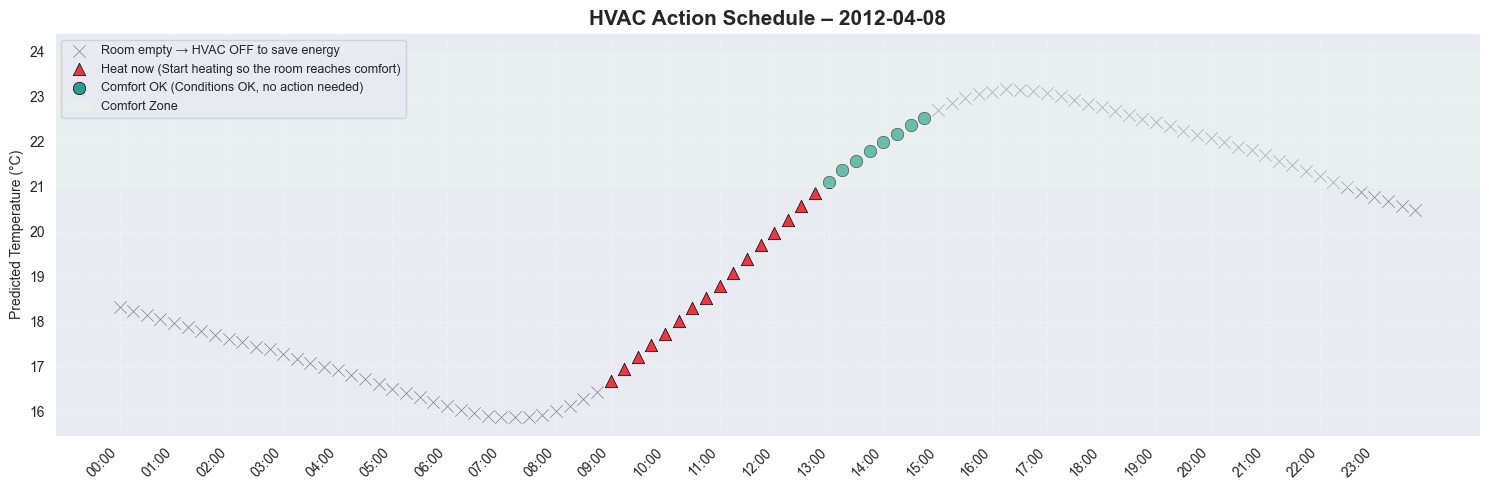

In [50]:

plt.figure(figsize=(15, 5))

# --- Marker & color mapping ---
marker_map = {
    "Heat now (Start heating so the room reaches comfort)": "^",
    "Cool now (Start cooling to avoid overheating)": "v",
    "Comfort OK (Conditions OK, no action needed)": "o",
    "Room empty → HVAC OFF to save energy": "x"
}

color_map = {
    "Heat now (Start heating so the room reaches comfort)": "#e63946",
    "Cool now (Start cooling to avoid overheating)": "#1d3557",
    "Comfort OK (Conditions OK, no action needed)": "#2a9d8f",
    "Room empty → HVAC OFF to save energy": "gray"
}

# X positions for plotting
x = np.arange(len(schedule_df))

# ---- Scatter each action category ----
for action in schedule_df["Action"].unique():
    mask = schedule_df["Action"] == action
    plt.scatter(
        x[mask],
        schedule_df["Pred_T+15°C"][mask],
        label=action,
        s=80,
        color=color_map[action],
        marker=marker_map[action],
        edgecolors="black",
        linewidth=0.5
    )

# ---- Comfort zone shading ----
COMFORT_LOW = 21.0
COMFORT_HIGH = 24.0
plt.axhspan(COMFORT_LOW, COMFORT_HIGH,
            color="#e8f8e8", alpha=0.35, label="Comfort Zone")

# ---- Time labels every hour ----
# schedule_df has 15-min steps → 4 steps = 1 hour
time_labels = schedule_df["Time"]
hour_indices = np.arange(0, len(schedule_df), 4)

plt.xticks(hour_indices, time_labels.iloc[hour_indices], rotation=45, ha="right")

# ---- Formatting ----
plt.ylabel("Predicted Temperature (°C)")
plt.title(f"HVAC Action Schedule – {day}", fontsize=15, weight="bold")

plt.grid(alpha=0.3, linestyle="--")
plt.legend(fontsize=9, loc="upper left")
plt.tight_layout()
plt.show()
